# Energy Consumption by household in the UK


**This notebook reads in data of household half-hourly energy consumption of 5,567 households between November 2011 and February 2014. Once the data is read in, it is cleaned, analysed, then prepared for predictive analysis. Two predictive models are combined together to create one that predicts energy usage at an individual household level.**

References: https://www.kaggle.com/jeanmidev/smart-meters-in-london

https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

## Data Preparation

First, the relevant libraries are imported, and the google drive is mounted.

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-3661cbf65bf4>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


### Energy Data

#### Function to process one file at a time

The half-hourly energy readings are in 102 separated files. This comes in handy, since attempting to read all that data in at once would crash the notebook. A function is created, which reads in a specific file, creates a dataframe and returns it after cleaning it. The files will be read 14 at a time. This is a number that allows us to read the data in quickly without exceeding the RAM limit. Additionally, the data types are changed:

*   Energy from float64 to float16
*   Tstp(time) from string to datetime
*   ID from string to int16

The number after "float" or "int" represents how many numbers can be held. For example, int16 can contain numbers from -32,768 to 32,767. Finally, null values are dropped.
These modifications benefits both data analysis the data RAM efficient processing.


In [ ]:
def process_hh_df(num):
    '''
    Processes individual files from the half hourly dataset for maximum
    memory efficiency
    Input: An integer for the corresponding file name
    Output: A cleaned dataframe
    '''
    # Get the specific filename
    filename = "C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data/halfhourly_dataset/halfhourly_dataset/block_"+str(num)+".csv"
    # Parse it as a dataframe
    energy = pd.read_csv(filename)
    # Dropp al null energy values
    energy['energy(kWh/hh)'] = pd.to_numeric(energy['energy(kWh/hh)'], errors='coerce')
    # Change energy data type to float16
    energy['energy(kWh/hh)'] = energy['energy(kWh/hh)'].astype(np.float16)
    # Change tstp to datetime
    energy['tstp'] = pd.to_datetime(energy['tstp'],format='%Y-%m-%d %H:%M:%S.%f')
    # Remove the first 3 characters of id and turn it to an int16
    energy.LCLid = energy.LCLid.apply(lambda a: int(a[3:])).astype(np.int16)
    # Drop null values
    energy = energy.dropna()
    return energy

#### Reading in first files and removing duplicates

The dataset contains duplicates which must be removed. Attempting to drop them all at once consumes too much RAM. Therefore, after loading every 5 frames, duplicates are dropped. Data from 2500 houses is loaded in

In [ ]:
### Combining all blocks ###

# Initialize a list to hold a list of 14 dataframes, one for each file
list_of_frames = []
# Initialize the final DataFrame
energy = pd.DataFrame()

# Loop through the first 14 files 
for num in range(0, 14):
    # Append to the list
    list_of_frames.append(process_hh_df(num))
    # Incrementing num for tracking purposes
    num+=1
    # Drop duplicates every 14 files
    if num % 10 == 0:
      # Concatenate previous 14 frames into one
      energy_temp = pd.concat(list_of_frames)
      # Drop duplicates within the 14 frames
      energy_temp.drop_duplicates(subset=['tstp', 'LCLid'], inplace=True)
      # Concatenate the new frame to the existing one
      energy = pd.concat([energy, energy_temp])
      # Drop duplicates again
      energy.drop_duplicates(subset=['tstp', 'LCLid'], inplace=True)
      # Reset the list of frames
      list_of_frames = []
      # Print current state
      print(f'------------Creating DataFrame, {num} out of 14. {energy.shape[0]} rows so far----------------')

------------Creating DataFrame, 10 out of 14. 14515190 rows so far----------------


In [ ]:
energy.shape

(14515190, 3)

Just the first 14 files have 14.5 million rows

#### Read in the household information

**Twenty houses for each group will be used in Masterarbeit to leverage household specific data.**

This data will later be grouped with the half-hourly readings to create a dataframe of individual house readings which will be used for training the second model.

In [ ]:
## Importing informations_households.csv for Acorn Info

df_household = pd.read_csv("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data/other_information/informations_households.csv", encoding="utf-8")


df_household

LCLid stdorToU    Acorn Acorn_grouped       file
0     MAC005492      ToU   ACORN-        ACORN-    block_0
1     MAC001074      ToU   ACORN-        ACORN-    block_0
2     MAC000002      Std  ACORN-A      Affluent    block_0
3     MAC003613      Std  ACORN-A      Affluent    block_0
4     MAC003597      Std  ACORN-A      Affluent    block_0
...         ...      ...      ...           ...        ...
5561  MAC002056      Std  ACORN-U       ACORN-U  block_111
5562  MAC004587      Std  ACORN-U       ACORN-U  block_111
5563  MAC004828      Std  ACORN-U       ACORN-U  block_111
5564  MAC001704      ToU  ACORN-U       ACORN-U  block_111
5565  MAC002774      ToU  ACORN-U       ACORN-U  block_111

[5566 rows x 5 columns]

Getting the category mapping codes for later usage, before changing the data type of the columns:

In [ ]:
# Get the labels in the Masterarbeit of their categories
Acorn_codes = df_household.Acorn.astype('category').cat.categories

In [ ]:
# Keep only the last letter:
Acorn_codes = Acorn_codes.map(lambda a: a[-1])
Acorn_codes

Index(['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'U'],
      dtype='object')

In [ ]:
Acorn_grouped_codes = df_household.Acorn_grouped.astype('category').cat.categories
Acorn_grouped_codes

Index(['ACORN-', 'ACORN-U', 'Adversity', 'Affluent', 'Comfortable'], dtype='object')

To minimize RAM usage, instead of using the string name of the acorns and tariff, their categorical codes are utilised instead.

In [ ]:
# Change from string to integer codes, to save up memory
for col in ['stdorToU','Acorn','Acorn_grouped']:
  temp = pd.Categorical(df_household[col])
  df_household[col] = temp.codes
df_household.drop('file',axis=1,inplace=True)

In [ ]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LCLid          5566 non-null   object
 1   stdorToU       5566 non-null   int8  
 2   Acorn          5566 non-null   int8  
 3   Acorn_grouped  5566 non-null   int8  
dtypes: int8(3), object(1)
memory usage: 59.9+ KB


The IDs are all precedeed by the "MAC" string. This is dropped, and the ID is stored as an int16 type.

In [ ]:
df_household.LCLid = df_household.LCLid.apply(lambda a: int(a[3:])).astype(np.int16)

In [ ]:
df_household

LCLid  stdorToU  Acorn  Acorn_grouped
0      5492         1      0              0
1      1074         1      0              0
2         2         0      1              3
3      3613         0      1              3
4      3597         0      1              3
...     ...       ...    ...            ...
5561   2056         0     18              1
5562   4587         0     18              1
5563   4828         0     18              1
5564   1704         1     18              1
5565   2774         1     18              1

[5566 rows x 4 columns]

In [ ]:
df_household.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/df_household.csv', index=False)



```
# This is formatted as code
```

Looking to utilize data of 20 houses from each Acorn.

In [ ]:
houses_to_use = []
for i in df_household['Acorn'].unique():
  houses_this_acorn = df_household['LCLid'][df_household['Acorn']==i][:20].values
  houses_to_use.append(houses_this_acorn)

In [ ]:
for Acorn in houses_to_use:
  print(len(Acorn))

2
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


There are only 2 houses in Acorn Group 0, the others have at least 10 houses each.

Creating a 1D list with all the houses to keep

In [ ]:
all_houses_to_use = []
for houses in houses_to_use:
  all_houses_to_use.extend(houses)

In [ ]:
energy_houses = energy[energy['LCLid'].isin(all_houses_to_use)]

In [ ]:
energy_houses

LCLid                tstp  energy(kWh/hh)
0            2 2012-10-12 00:30:00        0.000000
1            2 2012-10-12 01:00:00        0.000000
2            2 2012-10-12 01:30:00        0.000000
3            2 2012-10-12 02:00:00        0.000000
4            2 2012-10-12 02:30:00        0.000000
...        ...                 ...             ...
1419060   4814 2014-02-27 22:00:00        0.018005
1419061   4814 2014-02-27 22:30:00        0.013000
1419062   4814 2014-02-27 23:00:00        0.050995
1419063   4814 2014-02-27 23:30:00        0.024002
1419064   4814 2014-02-28 00:00:00        0.013000

[2270889 rows x 3 columns]

#### Reading and processing the rest of the files

Next, all the steps previously discussed are combined together to read in the rest of the files.
The dataframes are appended to the final houses list and averages for each half hour time period are calculated.

In [ ]:
'''
This cell parses the rest of the files
'''
for i in range(1,8):
  list_of_frames=[]
  energy = pd.DataFrame()
  # Define start and end index
  start, end = 14*i, 14*(i+1)
  # Loop through 14 files at a time
  ############################# Read in Data ##################################
  print('Reading in data...')
  for num in range(start, end):
    # Append to the list
    list_of_frames.append(process_hh_df(num))
    # Incrementing num for tracking purposes
    num+=1
    # Drop duplicates every 10 files
    if num % 10 == 0:
      # Concatenate previous 10 frames into one
      energy_temp = pd.concat(list_of_frames)
      # Concatenate the new frame to the existing one
      energy = pd.concat([energy, energy_temp])
      # Drop duplicates
      energy.drop_duplicates(subset=['tstp', 'LCLid'], inplace=True)
      # Delete temp
      del energy_temp
      # Reset the list of frames
      list_of_frames = []
      # Print current state
      print(f'------------Creating DataFrame, {num} out of 112. {energy.shape[0]} rows so far----------------')

  del list_of_frames
  #############XX############## Read in Data ###############XX################

  new_energy = energy[energy['LCLid'].isin(all_houses_to_use)]
  energy_houses=pd.concat([energy_houses, new_energy])


Reading in data...
------------Creating DataFrame, 20 out of 112. 9296653 rows so far----------------
Reading in data...
------------Creating DataFrame, 30 out of 112. 3344289 rows so far----------------
------------Creating DataFrame, 40 out of 112. 18825084 rows so far----------------
Reading in data...
------------Creating DataFrame, 50 out of 112. 12780141 rows so far----------------
Reading in data...
------------Creating DataFrame, 60 out of 112. 5947897 rows so far----------------
------------Creating DataFrame, 70 out of 112. 20197818 rows so far----------------
Reading in data...
------------Creating DataFrame, 80 out of 112. 14671082 rows so far----------------
Reading in data...
------------Creating DataFrame, 90 out of 112. 8534877 rows so far----------------
Reading in data...
------------Creating DataFrame, 100 out of 112. 3235975 rows so far----------------
------------Creating DataFrame, 110 out of 112. 18276355 rows so far----------------


In [ ]:
energy_houses.LCLid.unique().shape

(282,)

In [ ]:
energy_houses

LCLid                tstp  energy(kWh/hh)
0            2 2012-10-12 00:30:00        0.000000
1            2 2012-10-12 01:00:00        0.000000
2            2 2012-10-12 01:30:00        0.000000
3            2 2012-10-12 02:00:00        0.000000
4            2 2012-10-12 02:30:00        0.000000
...        ...                 ...             ...
1391728   5124 2014-02-27 22:00:00        0.672852
1391729   5124 2014-02-27 22:30:00        0.589844
1391730   5124 2014-02-27 23:00:00        0.551758
1391731   5124 2014-02-27 23:30:00        0.519043
1391732   5124 2014-02-28 00:00:00        0.389893

[8092717 rows x 3 columns]



and therefore only 142 out of the 192 searched houses *appear* in the dataframe.

In [ ]:
energy_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv', index=False)

In [ ]:
energy_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

#### Save the households dataframe

Group all data by half-hours

In [ ]:
energy_grouped_by_time = energy_houses.groupby('tstp')

Get the available half-hour data

In [ ]:
time_period = energy_grouped_by_time.mean().index

In [ ]:
time_period.shape

(39578,)

Get all available houses for each half hour

In [ ]:
houses_available = energy_grouped_by_time['LCLid'].apply(list)

In [ ]:
houses_available

tstp
2011-11-26 11:30:00                                                [183]
2011-11-26 12:00:00                                                [183]
2011-11-26 12:30:00                                                [183]
2011-11-26 13:00:00                                                [183]
2011-11-26 13:30:00                                                [183]
                                             ...                        
2014-02-27 22:00:00    [2, 246, 3281, 3305, 3348, 3388, 3394, 3400, 3...
2014-02-27 22:30:00    [2, 246, 3281, 3305, 3348, 3388, 3394, 3400, 3...
2014-02-27 23:00:00    [2, 246, 3281, 3305, 3348, 3388, 3394, 3400, 3...
2014-02-27 23:30:00    [2, 246, 3281, 3305, 3348, 3388, 3394, 3400, 3...
2014-02-28 00:00:00    [2, 246, 3281, 3305, 3348, 3388, 3394, 3400, 3...
Name: LCLid, Length: 39578, dtype: object

Below takes a long time to run ~ 3 hours 



In [ ]:
import random

lst_readings = [] #init list of one-row dataframes for each half-hour reading
for i in range (len(houses_available)): #pointer to loop through grouped by time data
  houses_this_hh = houses_available[i] #get all houses for this half-hour
  this_house = random.choice(houses_this_hh) #pick one at random between these
  this_reading = energy_houses[
                        (energy_houses['tstp']==houses_available.index[i]) & (energy_houses['LCLid']==this_house)]
  lst_readings.append(this_reading)
  if i%1000==0:
    print(f'{i} out of {len(houses_available)} executed')

0 out of 39578 executed
1000 out of 39578 executed
2000 out of 39578 executed
3000 out of 39578 executed
4000 out of 39578 executed
5000 out of 39578 executed
6000 out of 39578 executed
7000 out of 39578 executed
8000 out of 39578 executed
9000 out of 39578 executed
10000 out of 39578 executed
11000 out of 39578 executed
12000 out of 39578 executed
13000 out of 39578 executed
14000 out of 39578 executed
15000 out of 39578 executed
16000 out of 39578 executed
17000 out of 39578 executed
18000 out of 39578 executed
19000 out of 39578 executed
20000 out of 39578 executed
21000 out of 39578 executed
22000 out of 39578 executed
23000 out of 39578 executed
24000 out of 39578 executed
25000 out of 39578 executed
26000 out of 39578 executed
27000 out of 39578 executed
28000 out of 39578 executed
29000 out of 39578 executed
30000 out of 39578 executed
31000 out of 39578 executed
32000 out of 39578 executed
33000 out of 39578 executed
34000 out of 39578 executed
35000 out of 39578 executed
36000

In [ ]:
energy_households = pd.concat(lst_readings)

In [ ]:
energy_households.reset_index(inplace=True ,drop=True)

In [ ]:
energy_households

LCLid                 tstp  energy(kWh/hh)
0        183  2011-11-26 11:30:00           0.127
1        183  2011-11-26 12:00:00           0.178
2        183  2011-11-26 12:30:00           0.352
3        183  2011-11-26 13:00:00           0.215
4        183  2011-11-26 13:30:00           0.135
...      ...                  ...             ...
39573    953  2014-02-27 22:00:00           0.171
39574   5166  2014-02-27 22:30:00           0.504
39575    278  2014-02-27 23:00:00           0.176
39576   2595  2014-02-27 23:30:00           0.136
39577   2041  2014-02-28 00:00:00           0.055

[39578 rows x 3 columns]

In [ ]:
energy_households = energy_households.merge(df_household, on='LCLid')

In [ ]:
energy_households

LCLid                 tstp  energy(kWh/hh)  stdorToU  Acorn  \
0        183  2011-11-26 11:30:00           0.127         0      7   
1        183  2011-11-26 12:00:00           0.178         0      7   
2        183  2011-11-26 12:30:00           0.352         0      7   
3        183  2011-11-26 13:00:00           0.215         0      7   
4        183  2011-11-26 13:30:00           0.135         0      7   
...      ...                  ...             ...       ...    ...   
39573   3559  2014-01-30 02:00:00           0.080         1      3   
39574   3559  2014-02-04 05:30:00           0.067         1      3   
39575   3559  2014-02-09 17:30:00           0.406         1      3   
39576   3559  2014-02-15 07:30:00           0.145         1      3   
39577   3559  2014-02-15 19:30:00           0.348         1      3   

       Acorn_grouped  
0                  4  
1                  4  
2                  4  
3                  4  
4                  4  
...              ...  
39573              3  
39574              3  
39575              3  
39576              3  
39577              3  

[39578 rows x 6 columns]

In [ ]:
energy_households.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/energy_households.csv',index=False)
#energy_households.to_csv('energy_households.csv',index=False)

#### Load data

In [ ]:
energy_households = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/energy_households.csv')
#energy_households = pd.read_csv('energy_households.csv')

In [ ]:
energy_households

LCLid                 tstp  energy(kWh/hh)  stdorToU  Acorn  \
0        183  2011-11-26 11:30:00           0.127         0      7   
1        183  2011-11-26 12:00:00           0.178         0      7   
2        183  2011-11-26 12:30:00           0.352         0      7   
3        183  2011-11-26 13:00:00           0.215         0      7   
4        183  2011-11-26 13:30:00           0.135         0      7   
...      ...                  ...             ...       ...    ...   
39573   3559  2014-01-30 02:00:00           0.080         1      3   
39574   3559  2014-02-04 05:30:00           0.067         1      3   
39575   3559  2014-02-09 17:30:00           0.406         1      3   
39576   3559  2014-02-15 07:30:00           0.145         1      3   
39577   3559  2014-02-15 19:30:00           0.348         1      3   

       Acorn_grouped  
0                  4  
1                  4  
2                  4  
3                  4  
4                  4  
...              ...  
39573              3  
39574              3  
39575              3  
39576              3  
39577              3  

[39578 rows x 6 columns]

### Weather Information

In [ ]:
### Importing weather information data ###
weather = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data/other_information/weather_hourly_darksky.csv')
weather

visibility  windBearing  temperature                 time  dewPoint  \
0            5.97          104        10.24  2011-11-11 00:00:00      8.86   
1            4.88           99         9.76  2011-11-11 01:00:00      8.83   
2            3.70           98         9.46  2011-11-11 02:00:00      8.79   
3            3.12           99         9.23  2011-11-11 03:00:00      8.63   
4            1.85          111         9.26  2011-11-11 04:00:00      9.21   
...           ...          ...          ...                  ...       ...   
21160       12.68          247         7.39  2014-02-15 19:00:00      3.06   
21161       13.78          249         6.56  2014-02-15 20:00:00      2.76   
21162       14.31          248         6.47  2014-02-15 21:00:00      2.71   
21163       14.31          248         5.96  2014-02-15 22:00:00      2.69   
21164       14.31          246         5.38  2014-02-15 23:00:00      2.60   

       pressure  apparentTemperature  windSpeed precipType  \
0       1016.76                10.24       2.77       rain   
1       1016.63                 8.24       2.95       rain   
2       1016.36                 7.76       3.17       rain   
3       1016.28                 7.44       3.25       rain   
4       1015.98                 7.24       3.70       rain   
...         ...                  ...        ...        ...   
21160    997.07                 3.91       6.08       rain   
21161    998.15                 3.03       5.61       rain   
21162    999.28                 3.06       5.25       rain   
21163   1000.33                 2.68       4.69       rain   
21164   1001.25                 1.77       5.09       rain   

                      icon  humidity        summary  
0      partly-cloudy-night      0.91  Partly Cloudy  
1      partly-cloudy-night      0.94  Partly Cloudy  
2      partly-cloudy-night      0.96  Partly Cloudy  
3                      fog      0.96          Foggy  
4                      fog      1.00          Foggy  
...                    ...       ...            ...  
21160  partly-cloudy-night      0.74  Partly Cloudy  
21161          clear-night      0.77          Clear  
21162          clear-night      0.77          Clear  
21163          clear-night      0.80          Clear  
21164          clear-night      0.82          Clear  

[21165 rows x 12 columns]

In [ ]:
# Clean weather df and turn time to datetime type
weather = weather.drop_duplicates()
weather = weather.dropna()
weather['time'] = pd.to_datetime(weather['time'],format='%Y-%m-%d %H:%M:%S.%f')

**In Masterarbeit to use half hourly data, the dataframe is duplicated, each measurement being used for 2 half hours**

In [ ]:
# Duplicate all rows
hh_weather = pd.DataFrame(np.repeat(weather.values,2,axis=0), columns=weather.columns)

In [ ]:
hh_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42304 entries, 0 to 42303
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visibility           42304 non-null  object        
 1   windBearing          42304 non-null  object        
 2   temperature          42304 non-null  object        
 3   time                 42304 non-null  datetime64[ns]
 4   dewPoint             42304 non-null  object        
 5   pressure             42304 non-null  object        
 6   apparentTemperature  42304 non-null  object        
 7   windSpeed            42304 non-null  object        
 8   precipType           42304 non-null  object        
 9   icon                 42304 non-null  object        
 10  humidity             42304 non-null  object        
 11  summary              42304 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 3.9+ MB


In [ ]:
# Increment half an hour to each of the newly added rows
for i in range(1, len(hh_weather), 2):
    hh_weather.time[i] = hh_weather.time[i-1] + pd.to_timedelta(30,'m')

In [ ]:
hh_weather

visibility windBearing temperature                time dewPoint  \
0           5.97         104       10.24 2011-11-11 00:00:00     8.86   
1           5.97         104       10.24 2011-11-11 00:30:00     8.86   
2           4.88          99        9.76 2011-11-11 01:00:00     8.83   
3           4.88          99        9.76 2011-11-11 01:30:00     8.83   
4            3.7          98        9.46 2011-11-11 02:00:00     8.79   
...          ...         ...         ...                 ...      ...   
42299      14.31         248        6.47 2014-02-15 21:30:00     2.71   
42300      14.31         248        5.96 2014-02-15 22:00:00     2.69   
42301      14.31         248        5.96 2014-02-15 22:30:00     2.69   
42302      14.31         246        5.38 2014-02-15 23:00:00      2.6   
42303      14.31         246        5.38 2014-02-15 23:30:00      2.6   

      pressure apparentTemperature windSpeed precipType                 icon  \
0      1016.76               10.24      2.77       rain  partly-cloudy-night   
1      1016.76               10.24      2.77       rain  partly-cloudy-night   
2      1016.63                8.24      2.95       rain  partly-cloudy-night   
3      1016.63                8.24      2.95       rain  partly-cloudy-night   
4      1016.36                7.76      3.17       rain  partly-cloudy-night   
...        ...                 ...       ...        ...                  ...   
42299   999.28                3.06      5.25       rain          clear-night   
42300  1000.33                2.68      4.69       rain          clear-night   
42301  1000.33                2.68      4.69       rain          clear-night   
42302  1001.25                1.77      5.09       rain          clear-night   
42303  1001.25                1.77      5.09       rain          clear-night   

      humidity        summary  
0         0.91  Partly Cloudy  
1         0.91  Partly Cloudy  
2         0.94  Partly Cloudy  
3         0.94  Partly Cloudy  
4         0.96  Partly Cloudy  
...        ...            ...  
42299     0.77          Clear  
42300      0.8          Clear  
42301      0.8          Clear  
42302     0.82          Clear  
42303     0.82          Clear  

[42304 rows x 12 columns]

In [ ]:
# Rename time column
energy_households.rename(columns={'tstp':'time'},inplace=True)

In [ ]:
# Change time data type to datetime of avg energies
energy_households['time'] = pd.to_datetime(energy_households['time'],format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
energy_households.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39578 entries, 0 to 39577
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   LCLid           39578 non-null  int64         
 1   time            39578 non-null  datetime64[ns]
 2   energy(kWh/hh)  39578 non-null  float64       
 3   stdorToU        39578 non-null  int64         
 4   Acorn           39578 non-null  int64         
 5   Acorn_grouped   39578 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 1.8 MB


In [ ]:
energy_households = energy_households.merge(hh_weather,on='time')  #energy
energy_households = energy_households.drop_duplicates()
energy_households = energy_households.dropna()

Add date info

In [ ]:
# Add datetime columns as integers
energy_households['year'] = pd.to_datetime(energy_households['time']).dt.year
energy_households['month'] = pd.to_datetime(energy_households['time']).dt.month.astype(np.int8)
energy_households['day'] = pd.to_datetime(energy_households['time']).dt.day.astype(np.int8)
energy_households['hour'] = pd.to_datetime(energy_households['time']).dt.hour.astype(np.int8) 
energy_households['weekday'] = pd.to_datetime(energy_households['time']).dt.dayofweek.astype(np.int8) 

In [ ]:
del weather
del hh_weather

### Holidays & Weekends

In [ ]:
### Holidays data
holiday = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data/other_information/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'])
holiday = holiday.rename(columns={'Bank holidays':'time'})
holiday

time                                          Type
0  2012-12-26                                    Boxing Day
1  2012-12-25                                 Christmas Day
2  2012-08-27                           Summer bank holiday
3  2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4  2012-04-06          Spring bank holiday (substitute day)
5  2012-07-05                        Early May bank holiday
6  2012-09-04                                 Easter Monday
7  2012-06-04                                   Good Friday
8  2012-02-01               New Year?s Day (substitute day)
9  2013-12-26                                    Boxing Day
10 2013-12-25                                 Christmas Day
11 2013-08-26                           Summer bank holiday
12 2013-05-27                           Spring bank holiday
13 2013-06-05                        Early May bank holiday
14 2013-01-04                                 Easter Monday
15 2013-03-29                                   Good Friday
16 2013-01-01                                New Year?s Day
17 2014-12-26                                    Boxing Day
18 2014-12-25                                 Christmas Day
19 2014-08-25                           Summer bank holiday
20 2014-05-26                           Spring bank holiday
21 2014-05-05                        Early May bank holiday
22 2014-04-21                                 Easter Monday
23 2014-04-18                                   Good Friday
24 2014-01-01                                New Year?s Day

**Creating a holiday indicator on weather data**

In [ ]:
# Merge Holidays data with weather_energy and holiday_ind will be of our use
energy_households = energy_households.merge(holiday, on = 'time', how='left')
# Change to 1 when there is holiday, and to 0 otherwise
energy_households['holiday_ind'] = np.where(energy_households['Type'].isna(),0,1)
energy_households.drop('Type',axis=1,inplace=True) #drop old column

In [ ]:
energy_households

LCLid                time  energy(kWh/hh)  stdorToU  Acorn  \
0        183 2011-11-26 11:30:00           0.127         0      7   
1        183 2011-11-26 12:00:00           0.178         0      7   
2        183 2011-11-26 12:30:00           0.352         0      7   
3        183 2011-11-26 13:00:00           0.215         0      7   
4        183 2011-11-26 13:30:00           0.135         0      7   
...      ...                 ...             ...       ...    ...   
39547   3559 2014-01-30 02:00:00           0.080         1      3   
39548   3559 2014-02-04 05:30:00           0.067         1      3   
39549   3559 2014-02-09 17:30:00           0.406         1      3   
39550   3559 2014-02-15 07:30:00           0.145         1      3   
39551   3559 2014-02-15 19:30:00           0.348         1      3   

       Acorn_grouped visibility windBearing temperature dewPoint  ...  \
0                  4      13.07         238       11.92     7.58  ...   
1                  4      12.83         239       12.48     7.31  ...   
2                  4      12.83         239       12.48     7.31  ...   
3                  4      13.07         243       12.61     7.57  ...   
4                  4      13.07         243       12.61     7.57  ...   
...              ...        ...         ...         ...      ...  ...   
39547              3       4.78          40        4.18     2.69  ...   
39548              3      13.81         225        5.63     2.26  ...   
39549              3      12.15         231        6.72    -1.73  ...   
39550              3      12.39         228        8.59      2.3  ...   
39551              3      12.68         247        7.39     3.06  ...   

      precipType                 icon humidity                  summary  year  \
0           rain    partly-cloudy-day     0.75            Partly Cloudy  2011   
1           rain    partly-cloudy-day     0.71            Partly Cloudy  2011   
2           rain    partly-cloudy-day     0.71            Partly Cloudy  2011   
3           rain    partly-cloudy-day     0.71            Mostly Cloudy  2011   
4           rain    partly-cloudy-day     0.71            Mostly Cloudy  2011   
...          ...                  ...      ...                      ...   ...   
39547       rain          clear-night      0.9                    Clear  2014   
39548       rain          clear-night     0.79                    Clear  2014   
39549       rain  partly-cloudy-night     0.55            Partly Cloudy  2014   
39550       rain                 wind     0.65  Windy and Mostly Cloudy  2014   
39551       rain  partly-cloudy-night     0.74            Partly Cloudy  2014   

      month day  hour  weekday  holiday_ind  
0        11  26    11        5            0  
1        11  26    12        5            0  
2        11  26    12        5            0  
3        11  26    13        5            0  
4        11  26    13        5            0  
...     ...  ..   ...      ...          ...  
39547     1  30     2        3            0  
39548     2   4     5        1            0  
39549     2   9    17        6            0  
39550     2  15     7        5            0  
39551     2  15    19        5            0  

[39552 rows x 23 columns]

In [ ]:
### Droping all the unneccessary columns and changing dtypes ###

weather_energy = energy_households[['time', 'year', 'month', 'day',
       'hour', 'weekday', 'energy(kWh/hh)', 'visibility', 'windBearing', 'temperature',
       'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity',
       'holiday_ind', 'stdorToU', 'Acorn', 'Acorn_grouped']]

In [ ]:
del holiday

In [ ]:
weather_energy

time  year  month  day  hour  weekday  energy(kWh/hh)  \
0     2011-11-26 11:30:00  2011     11   26    11        5           0.127   
1     2011-11-26 12:00:00  2011     11   26    12        5           0.178   
2     2011-11-26 12:30:00  2011     11   26    12        5           0.352   
3     2011-11-26 13:00:00  2011     11   26    13        5           0.215   
4     2011-11-26 13:30:00  2011     11   26    13        5           0.135   
...                   ...   ...    ...  ...   ...      ...             ...   
39547 2014-01-30 02:00:00  2014      1   30     2        3           0.080   
39548 2014-02-04 05:30:00  2014      2    4     5        1           0.067   
39549 2014-02-09 17:30:00  2014      2    9    17        6           0.406   
39550 2014-02-15 07:30:00  2014      2   15     7        5           0.145   
39551 2014-02-15 19:30:00  2014      2   15    19        5           0.348   

      visibility windBearing temperature dewPoint pressure  \
0          13.07         238       11.92     7.58  1026.96   
1          12.83         239       12.48     7.31  1026.25   
2          12.83         239       12.48     7.31  1026.25   
3          13.07         243       12.61     7.57  1025.28   
4          13.07         243       12.61     7.57  1025.28   
...          ...         ...         ...      ...      ...   
39547       4.78          40        4.18     2.69  1000.13   
39548      13.81         225        5.63     2.26   998.42   
39549      12.15         231        6.72    -1.73    988.9   
39550      12.39         228        8.59      2.3   983.69   
39551      12.68         247        7.39     3.06   997.07   

      apparentTemperature windSpeed humidity  holiday_ind  stdorToU  Acorn  \
0                   11.92      7.21     0.75            0         0      7   
1                   12.48      7.48     0.71            0         0      7   
2                   12.48      7.48     0.71            0         0      7   
3                   12.61      8.15     0.71            0         0      7   
4                   12.61      8.15     0.71            0         0      7   
...                   ...       ...      ...          ...       ...    ...   
39547                1.26      3.37      0.9            0         1      3   
39548                2.71      3.85     0.79            0         1      3   
39549                2.94      6.33     0.55            0         1      3   
39550                3.92     12.02     0.65            0         1      3   
39551                3.91      6.08     0.74            0         1      3   

       Acorn_grouped  
0                  4  
1                  4  
2                  4  
3                  4  
4                  4  
...              ...  
39547              3  
39548              3  
39549              3  
39550              3  
39551              3  

[39552 rows x 19 columns]


Include whether a day is weekend or not


In [ ]:
weather_energy['time'] = pd.to_datetime(weather_energy['time'])

In [ ]:
'''Use integer division (//) to test whether the dayofweek attribute of the 
index is less than 5. 
Normally this would return just a True or False, 
but tacking on the astype(float) at the end returns a 1 or 0 rather than a boolean
Ref: https://stackoverflow.com/questions/32278728/convert-dataframe-date-row-to-a-weekend-not-weekend-value/32280195
'''
weather_energy['weekend'] = ((weather_energy.time.dt.dayofweek) // 5 == 1).astype(int)

In [ ]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39552 entries, 0 to 39551
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 39552 non-null  datetime64[ns]
 1   year                 39552 non-null  int64         
 2   month                39552 non-null  int8          
 3   day                  39552 non-null  int8          
 4   hour                 39552 non-null  int8          
 5   weekday              39552 non-null  int8          
 6   energy(kWh/hh)       39552 non-null  float64       
 7   visibility           39552 non-null  object        
 8   windBearing          39552 non-null  object        
 9   temperature          39552 non-null  object        
 10  dewPoint             39552 non-null  object        
 11  pressure             39552 non-null  object        
 12  apparentTemperature  39552 non-null  object        
 13  windSpeed            39552 non-

In [ ]:
weather_energy.to_csv("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv",index=False)

## Exploratory Data Analysis

### Average energy & weather data analysis

***1. Temperature***

First reading in the previously saved dataset and reducing the sizes of the data types.

In [ ]:
# Set the time as index to group dates
weather = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')
weather.time = pd.to_datetime(weather['time'],format='%Y-%m-%d %H:%M:%S.%f')
weather.index = weather.time

# Change the rest of data types
dict_types={
    'windBearing':np.int16,
    'holiday_ind':np.int16,
    'temperature':np.float32,
    'windSpeed':np.float32,
    'humidity':np.float32,
    'pressure':np.float32,
    'dewPoint':np.float32,
    'visibility':np.float32,
    'apparentTemperature':np.float32,
    'day':np.int8
}
weather= weather.astype(dict_types)

weather.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39552 entries, 2011-11-26 11:30:00 to 2014-02-15 19:30:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 39552 non-null  datetime64[ns]
 1   year                 39552 non-null  int64         
 2   month                39552 non-null  int64         
 3   day                  39552 non-null  int8          
 4   hour                 39552 non-null  int64         
 5   weekday              39552 non-null  int64         
 6   energy(kWh/hh)       39552 non-null  float64       
 7   visibility           39552 non-null  float32       
 8   windBearing          39552 non-null  int16         
 9   temperature          39552 non-null  float32       
 10  dewPoint             39552 non-null  float32       
 11  pressure             39552 non-null  float32       
 12  apparentTemperature  39552 non-null  float32       
 

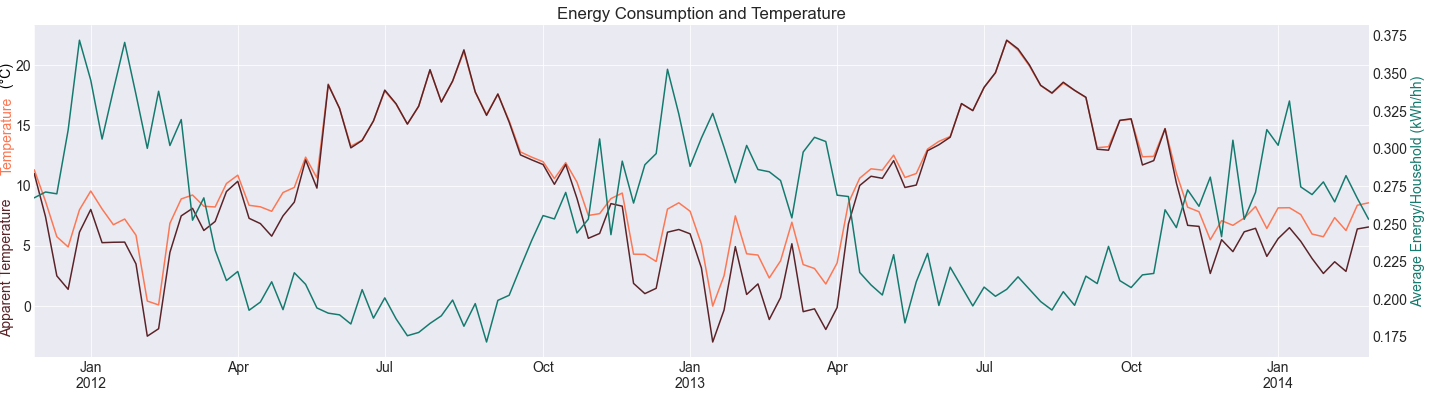

In [ ]:
# Change Font Size
import matplotlib
import seaborn as sns

matplotlib.rcParams.update({'font.size': 14})
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

# Define colors
green = '#157a6e'
red = "#5A2328"
orange = '#FC7753'

# Set the figure size and first axis
fig, ax1 = plt.subplots(figsize = (20,6))
# Plot weekly temperature
weather['temperature'].resample('W').mean().plot(color =orange)
# On the same axis, plot apparent temperature
weather['apparentTemperature'].resample('W').mean().plot(color=red)
# Create a new axis and scale it according to ax1
ax2 = ax1.twinx()
# Plot weekly average energy per household
weather['energy(kWh/hh)'].resample('W').mean().plot(color =green)
ax2.set_ylabel('Average Energy/Household (kWh/hh)',color = green)
# Change the coordinates of the y axis label for avg eenergy
ax2.xaxis.set_label_coords(0.02,0.46)

# Create a label with 3 different colors for the first axis
# The metric: degrees Celsius
ybox1 = TextArea(" (°C)", textprops=dict(
    color="k", size=14,rotation=90,ha='center',va='bottom'))
# Temperature
ybox2 = TextArea("Temperature", textprops=dict(
    color=orange, size=14,rotation=90,ha='center',va='bottom'))
# A separator
ybox3 = TextArea(" ",     textprops=dict(
    color="k", size=14,rotation=90,ha='center',va='bottom'))
# A label for apparent temperature
ybox4 = TextArea("Apparent Temperature", textprops=dict(
    color=red, size=14,rotation=90,ha='center',va='bottom'))


# Combine the four boxes
ybox_left = VPacker(children=[ybox1, ybox2, ybox3, ybox4],align="bottom", pad=0, sep=5)
# Set the boxe's properties
anchored_ybox_left = AnchoredOffsetbox(loc=8, child=ybox_left, pad=0., frameon=False, bbox_to_anchor=(-0.015, 0.03), 
                                  bbox_transform=ax1.transAxes)

# Set title and make the figure layout tight
plt.title('Energy Consumption and Temperature')
# style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

fig.tight_layout()
# Reset xlabel to be empty, add the box and show plot
ax1.set_xlabel('')
ax1.add_artist(anchored_ybox_left)
plt.grid(b = None, which='minor', color='w', linewidth=1.0)
#plt.rcParams["axes.grid"] = False
ax2.grid(False)

plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energy_tempreture.jpeg', dpi = 500)
plt.show()


As expected, energy consumption is negatively correlated with temperature. Negative spikes in temperature, such as the one in February 2012, are more strongly correlated with energy consumption than positive temperature spikes, such as in July 2013. The reason is probably that during warm periods people don't use heating anyways, whereas during cold times, households utilise more energy to keep a warm living ambient. 

***2. Humidity***


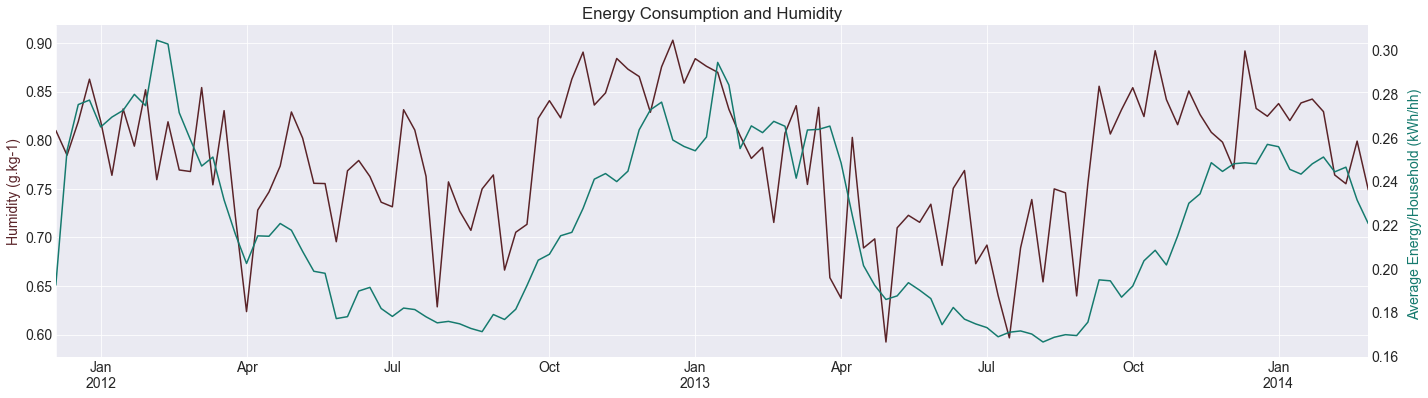

In [ ]:
# First axis, weekly humidity
fig, ax1 = plt.subplots(figsize = (20,6))
ax1= weather['humidity'].resample('W').mean().plot(color=red)
ax1.set_ylabel('Humidity (g.kg-1)',color = red)
ax2 = ax1.twinx()
# Weekly average energy/household
ax2= weather['avg_energy'].resample('W').mean().plot(color=green)
ax2.set_ylabel('Average Energy/Household (kWh/hh)',color = green)
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
ax1.set_xlabel('')
# Change the coordinates of the y axis label for avg eenergy
ax2.yaxis.set_label_coords(1.03,0.46)

plt.grid(b=True, which='major', color='w', linewidth=1.0)
ax2.grid(False)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energy_humidity.jpeg', dpi = 500)
plt.show()

The general trend of humidity is correlated to that of average energy. This probably is because in the UK colder seasons are assocciated with higher humidity.

***3. Visibility***

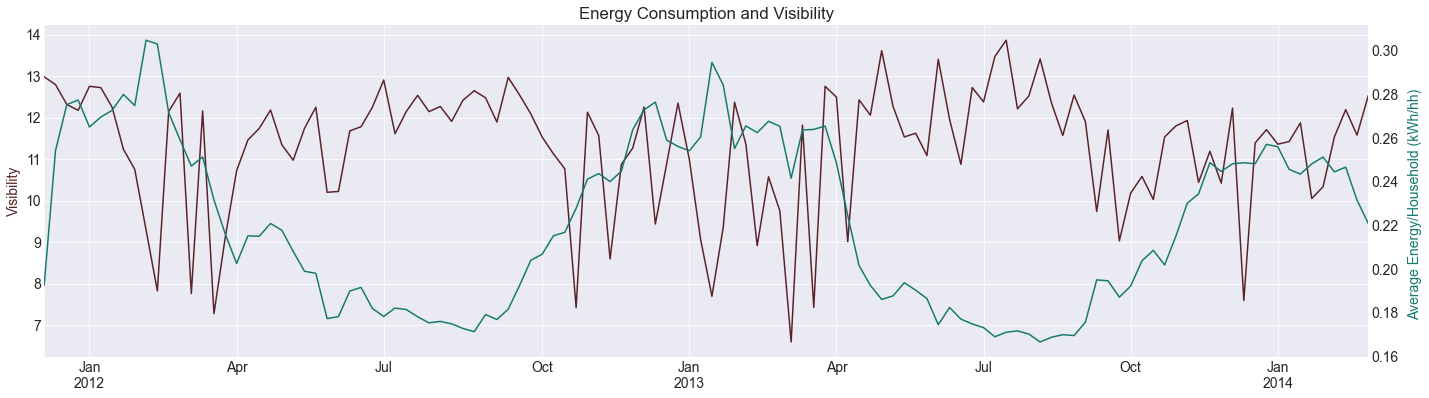

In [ ]:
# Plot visibility
import matplotlib.pylab as plt  

fig, ax1 = plt.subplots(figsize = (20,6))
ax1= weather['visibility'].resample('W').mean().plot(color=red)
plt.ylabel('Visibility',color = red)
# Plot average energy
ax2 = ax1.twinx()
ax2= weather['avg_energy'].resample('W').mean().plot(color=green)
plt.ylabel('Average Energy/Household (kWh/hh)',color = green)
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
ax1.set_xlabel('')
# Change the coordinates of the y axis label for avg energy
ax2.yaxis.set_label_coords(1.03,0.46)

plt.grid(b=True, which='both', color='w', linewidth=1.0)
ax2.grid(False)

plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energy_visibility.jpeg', dpi = 500)
plt.show()

The general trends are correlated, however the spikes are not. Colder seasons are assocciated with higher humidity and sometimes foggy weather.

***4.  Wind Speed***

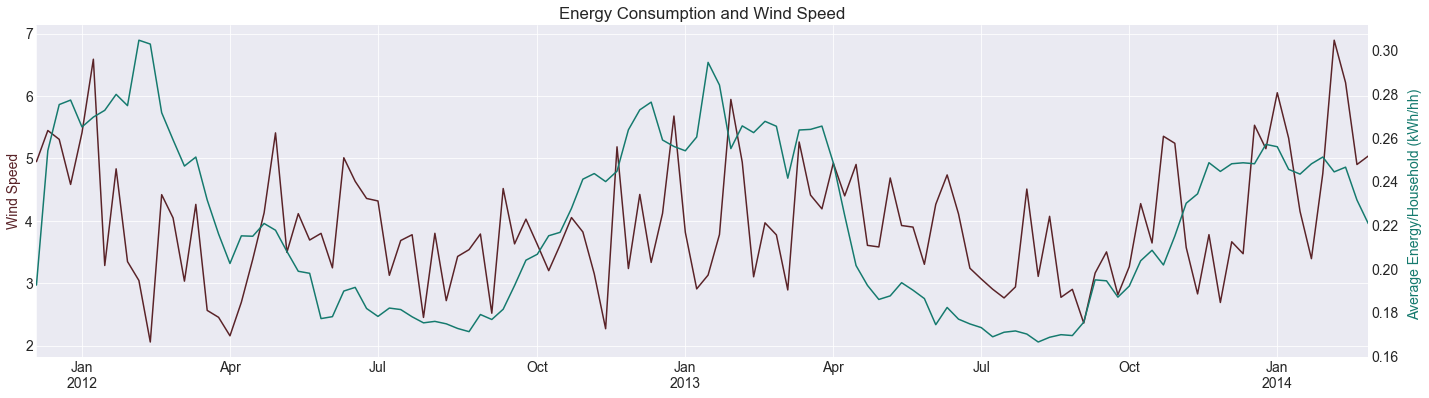

In [ ]:
# Plot wind speed
fig, ax1 = plt.subplots(figsize = (20,6))
ax1= weather['windSpeed'].resample('W').mean().plot(color=red)
ax1.set_ylabel('Wind Speed',color = red)
# Plot average energy use
ax2 = ax1.twinx()
ax2= weather['avg_energy'].resample('W').mean().plot(color=green)
ax2.set_ylabel('Average Energy/Household (kWh/hh)',color = green)
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
ax1.set_xlabel('')
plt.grid()
# Change the coordinates of the y axis label for avg energy
ax2.yaxis.set_label_coords(1.03,0.46)

plt.grid(b=True, which='both', color='w', linewidth=1.0)
ax2.grid(False)

plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energy_windSpeed.jpeg', dpi = 500)
plt.show()

The general trend of energy consumption weakly follows that of wind speed, however that may be due to slightly higher wind speeds in colder weather. Many spikes are not correlated, such as the one in January 2013. However, some spikes do appear to be related, for example the one in Feburary 2012.  

***5. dewPoint***

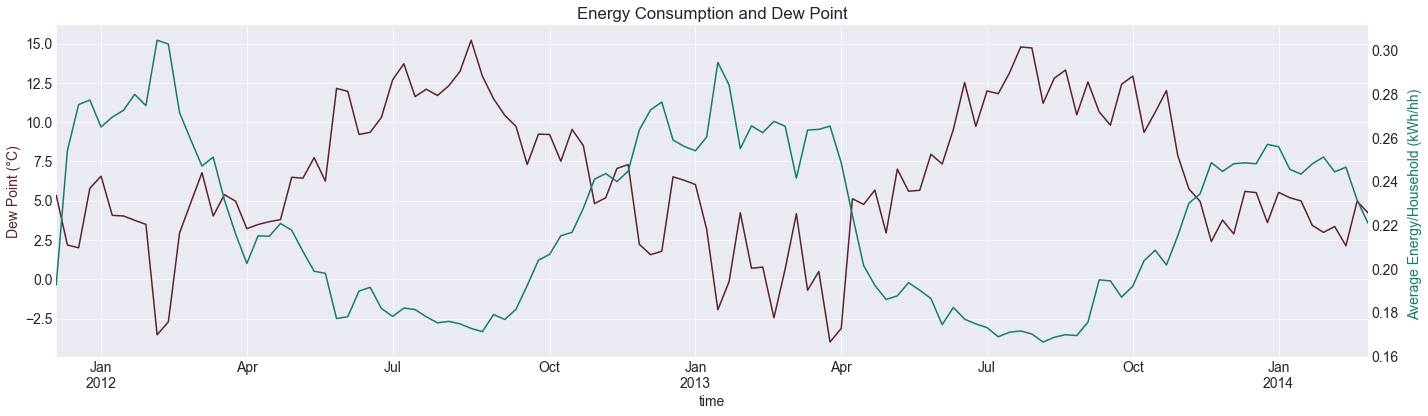

In [ ]:
# Plot dew point
fig, ax1 = plt.subplots(figsize = (20,6))
ax1= weather['dewPoint'].resample('W').mean().plot(color=red)
ax1.set_ylabel('Dew Point (°C)',color = red)
# Plot energy usage
ax2 = ax1.twinx()
ax2= weather['avg_energy'].resample('W').mean().plot(color=green)
ax2.set_ylabel('Average Energy/Household (kWh/hh)',color = green)
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.grid()
# Change the coordinates of the y axis label for avg energy
ax2.yaxis.set_label_coords(1.03,0.46)

plt.grid(b=True, which='both', color='w', linewidth=1.0)
ax2.grid(False)


plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energy_dewPoint.jpeg', dpi = 500)
plt.show()

### Correlation

#### Weather data

In [ ]:
# Obtain the correlation matrix and show it
cor_matrix = weather[['avg_energy','dewPoint', 'windSpeed','pressure', 'visibility', 
                             'humidity', 'temperature', 'apparentTemperature', 'windBearing']].corr()

cor_matrix

avg_energy  dewPoint  windSpeed  pressure  visibility  \
avg_energy             1.000000 -0.346308   0.145663 -0.018439    0.012705   
dewPoint              -0.346308  1.000000  -0.038742 -0.052787   -0.008530   
windSpeed              0.145663 -0.038742   1.000000 -0.380095    0.219592   
pressure              -0.018439 -0.052787  -0.380095  1.000000    0.009515   
visibility             0.012705 -0.008530   0.219592  0.009515    1.000000   
humidity              -0.056183  0.109005  -0.174749 -0.183666   -0.525253   
temperature           -0.294012  0.850058   0.039161  0.050900    0.244147   
apparentTemperature   -0.313358  0.862390  -0.038089  0.082379    0.201056   
windBearing           -0.016404  0.056078   0.063147 -0.012888    0.202667   

                     humidity  temperature  apparentTemperature  windBearing  
avg_energy          -0.056183    -0.294012            -0.313358    -0.016404  
dewPoint             0.109005     0.850058             0.862390     0.056078  
windSpeed           -0.174749     0.039161            -0.038089     0.063147  
pressure            -0.183666     0.050900             0.082379    -0.012888  
visibility          -0.525253     0.244147             0.201056     0.202667  
humidity             1.000000    -0.424197            -0.377025    -0.006802  
temperature         -0.424197     1.000000             0.987044     0.049243  
apparentTemperature -0.377025     0.987044             1.000000     0.054559  
windBearing         -0.006802     0.049243             0.054559     1.000000

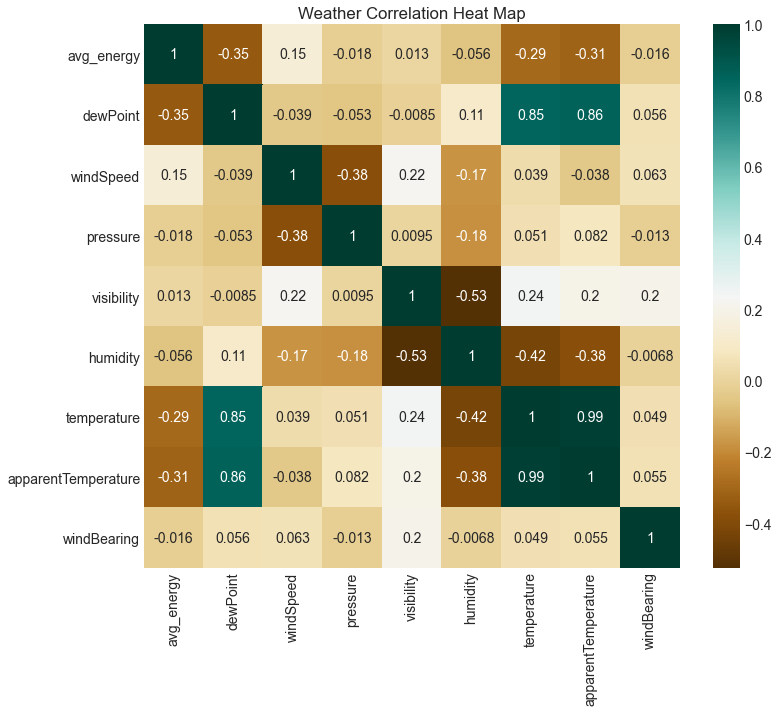

In [ ]:
# Show the correlation matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix,cmap="BrBG", annot = True)
plt.title('Weather Correlation Heat Map')
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_weatherCorrelation.jpeg', dpi = 500, bbox_inches='tight')
plt.show()

As previously seen, apparent temperature is strongly negatively correlated with average energy (around -31.3%). However, interestingly, the relation with dew point is even stronger (-34.6%). Many of the independent variables are related to each other, such as temperature, apparent temperature and dew point, or visibility and humidity. This may cause issues for the model as some variables may be given too much weight. The wind speed also appears significantly correlated with average energy (14.6%). Wind speed is in fact barely correlated with temperature at all (4%), and -4% with apparent temperature.

The ideal average energy usage predictive model should therefore choose the most important features and utilise a regularization parameter, to combat colinearity.

**1. Energy Consumption by Acorn**

First the labels for all existing Acorns are obtained

In [ ]:
# Get the indexes of Acorn present in the final dataframe
houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/household_data.csv')
indexes_acorn_codes = houses.Acorn.value_counts().index.sort_values()

In [ ]:
# Get all the respective codes
Acorn_codes = Acorn_codes[indexes_acorn_codes]

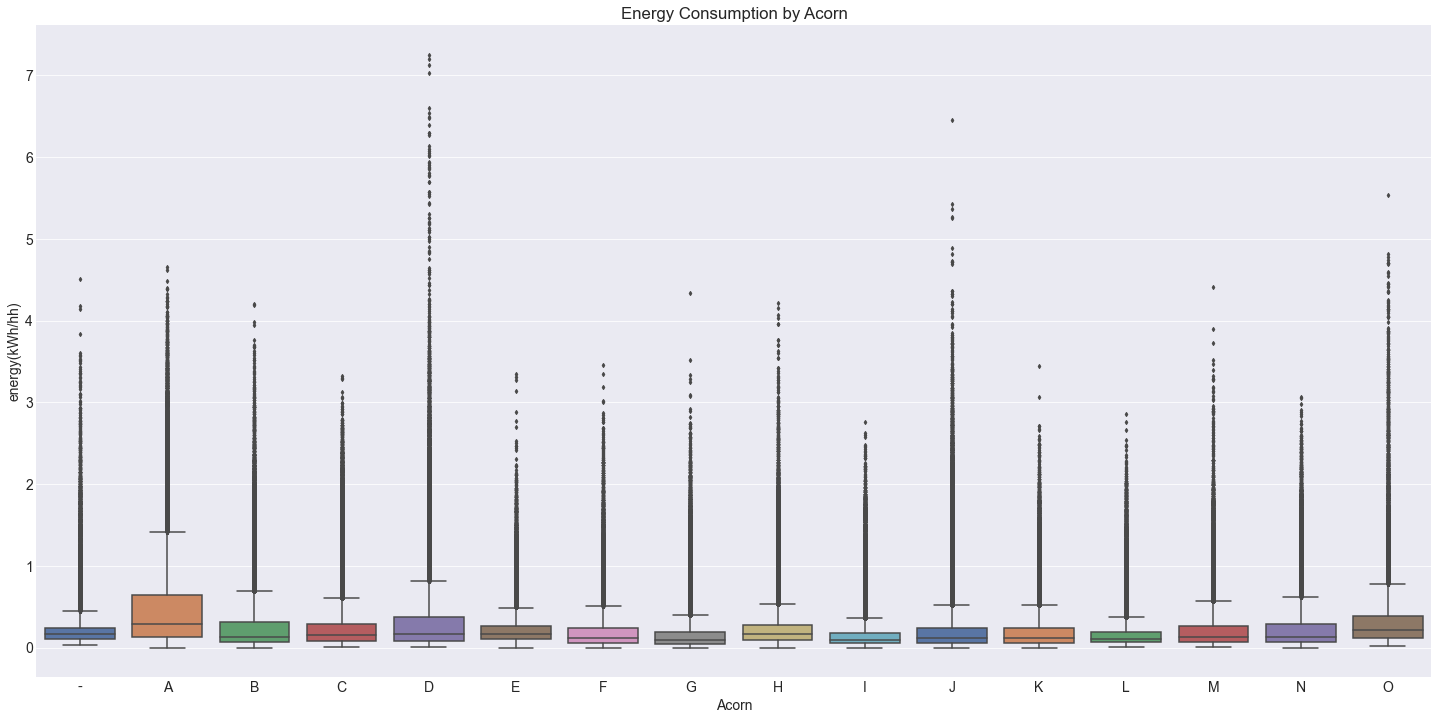

In [ ]:
# Import the seaborn library
import seaborn as sns
# Set figure size
plt.figure(figsize=(25,12))
# Create a boxplot of energy consumption for each Acorn
sns.boxplot(x='Acorn', y='energy(kWh/hh)', data=houses, fliersize=3,
            palette='deep')
# Title the plot and give labels to xticks
plt.title('Energy Consumption by Acorn')
plt.xticks(range(len(indexes_acorn_codes)), labels=Acorn_codes)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energyLoad_byAcorn.jpeg', dpi = 500)
plt.show()

Most Acorns have similar energy consumption, with most values on average less than 0.5, although all groups have some outliers of households who spend 3 or more kWh/hh.

Acorn Group A here are "Executive wealth". They have the largest interquartile range(Q1-Q3, the colored box area). Acorn-E are represnetative of "Career CLimbers", younger people and families living in smaller houses. Some outliers with the largest energy consumption come from this group. It is unclear why that may be, one potential explanation being that certain Acorn-E households are highly active all throughout day and night. 

Some households are not categorised in any Acorn ("-"), while others are missing: P (struggling estates) & U (not described in the user guide). 

Reference: https://acorn.caci.co.uk/downloads/Acorn-User-guide.pdf

**2. Energy Consumption by Acorn Group**

In [ ]:
# Get the indexes of Acorn present in the final dataframe
indexes_acorn_grouped_codes = houses.Acorn_grouped.value_counts().index.sort_values()

# Get all the respective codes
Acorn_grouped_codes = Acorn_grouped_codes[indexes_acorn_grouped_codes]

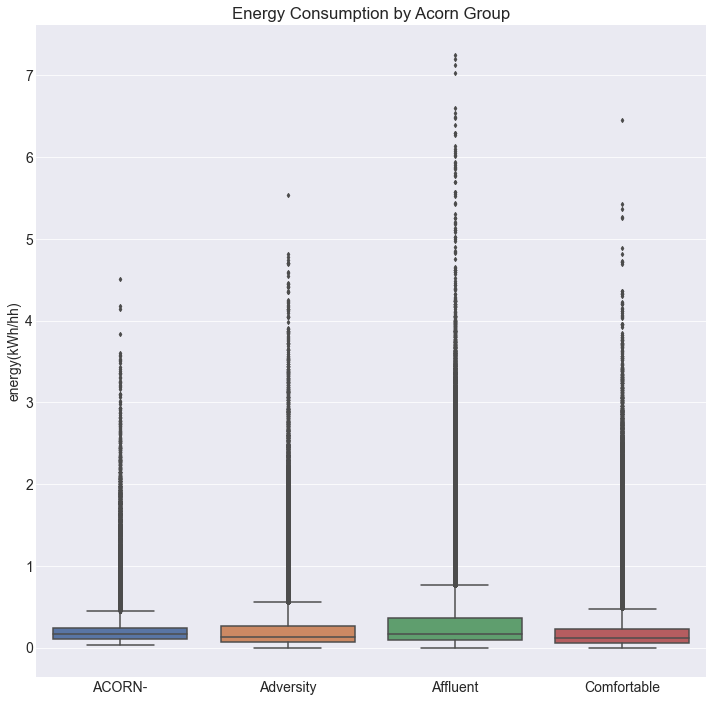

In [ ]:
plt.figure(figsize=(12,12))
sns.boxplot(x='Acorn_grouped', y='energy(kWh/hh)', data=houses, fliersize=3,
            palette='deep')
plt.xticks(range(len(Acorn_grouped_codes)), labels=Acorn_grouped_codes)
plt.title("Energy Consumption by Acorn Group")
plt.xlabel("")
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energyLoad_byAcornGroup.jpeg', dpi = 500)
plt.show()

The households are grouped into 3 categories: Adversity, Affluent, Comfortable, and some are left uncategorised. The affluent group has the largest interquartile range, largest mean and many outliers >1 kwH/hh.

**3. Energy Consumption by Tariff type**

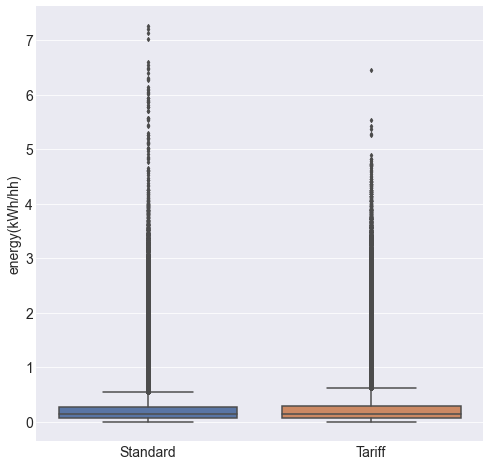

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(x='stdorToU', y='energy(kWh/hh)', data=houses, fliersize=3,
            palette='deep')
plt.xticks([0,1], ['Standard','Tariff'])
plt.xlabel('')
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/plots_computed/Scenario4/S4_energyLoad_Tariff.jpeg', dpi = 500)
plt.show()

Extremely similar Standard and Tariff energy consumption, although households on a standard paying plan have fewer outleirs of energy consumption >3 kwh/hh. One reason for this might be that people who pay according to how much they consume are more likely to be more economic. However, it is also true that there are 5 times more people on a standard paying plan.

## PreProcessing

In [2]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv',
                             keep_default_na=False)

In [3]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [4]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Reference: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [6]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  var1(t-20)  var1(t-19)  \
24       0.127       0.178       0.352       0.215       0.135       0.091   
25       0.178       0.352       0.215       0.135       0.091       0.112   
26       0.352       0.215       0.135       0.091       0.112       0.893   

    var1(t-18)  var1(t-17)  var1(t-16)  var1(t-15)  ...  var1(t-9)  var1(t-8)  \
24       0.112       0.893       0.453       0.237  ...      1.106      1.052   
25       0.893       0.453       0.237       0.283  ...      1.052      0.300   
26       0.453       0.237       0.283       0.231  ...      0.300      0.346   

    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
24      0.300      0.346      0.390      0.902      0.380      0.723   
25      0.346      0.390      0.902      0.380      0.723      0.170   
26      0.390      0.902      0.380      0.723      0.170      0.072   

    var1(t-1)  var1(t)  
24      0.170    0.072  
25      0.072    0.091  
26      0.091    0.054  

[3 rows x 25 columns]

In [7]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

year  month  day  hour  weekday  energy(kWh/hh)  visibility  \
24     2011     11   26    23        5           0.072       13.70   
25     2011     11   27     0        6           0.091       14.13   
26     2011     11   27     0        6           0.054       14.13   
27     2011     11   27     1        6           0.068       13.60   
28     2011     11   27     1        6           0.084       13.60   
...     ...    ...  ...   ...      ...             ...         ...   
39547  2014      1   30     2        3           0.080        4.78   
39548  2014      2    4     5        1           0.067       13.81   
39549  2014      2    9    17        6           0.406       12.15   
39550  2014      2   15     7        5           0.145       12.39   
39551  2014      2   15    19        5           0.348       12.68   

       windBearing  temperature  dewPoint  ...  var1(t-9)  var1(t-8)  \
24             232        11.59      7.18  ...      1.106      1.052   
25             229        11.98      7.98  ...      1.052      0.300   
26             229        11.98      7.98  ...      0.300      0.346   
27             233        12.08      8.28  ...      0.346      0.390   
28             233        12.08      8.28  ...      0.390      0.902   
...            ...          ...       ...  ...        ...        ...   
39547           40         4.18      2.69  ...      0.341      0.085   
39548          225         5.63      2.26  ...      0.085      0.827   
39549          231         6.72     -1.73  ...      0.827      0.070   
39550          228         8.59      2.30  ...      0.070      0.720   
39551          247         7.39      3.06  ...      0.720      0.198   

       var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
24         0.300      0.346      0.390      0.902      0.380      0.723   
25         0.346      0.390      0.902      0.380      0.723      0.170   
26         0.390      0.902      0.380      0.723      0.170      0.072   
27         0.902      0.380      0.723      0.170      0.072      0.091   
28         0.380      0.723      0.170      0.072      0.091      0.054   
...          ...        ...        ...        ...        ...        ...   
39547      0.827      0.070      0.720      0.198      0.322      0.115   
39548      0.070      0.720      0.198      0.322      0.115      2.586   
39549      0.720      0.198      0.322      0.115      2.586      0.080   
39550      0.198      0.322      0.115      2.586      0.080      0.067   
39551      0.322      0.115      2.586      0.080      0.067      0.406   

       var1(t-1)  var1(t)  
24         0.170    0.072  
25         0.072    0.091  
26         0.091    0.054  
27         0.054    0.068  
28         0.068    0.084  
...          ...      ...  
39547      2.586    0.080  
39548      0.080    0.067  
39549      0.067    0.406  
39550      0.406    0.145  
39551      0.145    0.348  

[39528 rows x 44 columns]

In [8]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[2.01100000e+03, 1.10000000e+01, 2.60000000e+01, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [2.01400000e+03, 2.00000000e+00, 9.00000000e+00, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 48 readings, corresponding to 24h, are set as the testing set, and the rest is training set

In [9]:
# split into train and test sets
train = reframed[:(len(reframed)-48), :]
test = reframed[(len(reframed)-48):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [10]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [11]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

The scaler must be fit on just the training set, to prevent overfitting (which means the prediction model following the trends of the training set too closely and therefore including noise in its prediction, which reduces its performance on the test set).

In [12]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [13]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [14]:
train_X.shape

(39480, 43)

## Household energy models

Models are created separately. Lists are held with their performances, so a dataframe can be plotted at the end to compare them.

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

The model is fit on the training set.

In [18]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

Training time: 0.043 s


array([ 3.00933846e-10,  3.48266649e-10, -1.22427113e-11,  3.76049342e-10,
        7.24236770e-11,  4.89500000e+00, -3.81403727e-10,  2.79253299e-11,
       -9.94707417e-10,  2.07054445e-09, -3.68285632e-10, -1.09620234e-09,
       -5.46354899e-11, -1.41936740e-09, -2.52715756e-09, -8.38278313e-11,
        1.00197110e-10,  6.02838871e-11, -6.86171127e-11, -2.02190700e-11,
       -1.64808651e-09,  1.39106838e-10,  1.87380006e-09, -1.21726220e-09,
       -1.94786211e-09,  1.13712002e-09,  2.49168185e-09,  5.84785982e-10,
       -1.70278228e-09, -2.38154466e-10, -6.62935430e-10, -3.12878932e-10,
       -4.82384806e-10,  1.76510224e-09,  1.78975889e-09,  1.40633002e-09,
        1.57789364e-10, -7.17901277e-10, -1.74974910e-10, -1.77186116e-09,
        3.97362538e-09,  2.39511450e-09,  2.18615740e-09])

A prediction is made on the test set.

In [19]:
# make a prediction
yhat = model.predict(test_X)

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [21]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999999999999
Mse:  0.000000000000000
Rmse: 0.000000010170844
Mae:  0.000000006226212
Mape:  0.000001986236664
Training time: 0.043 s


In [22]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [23]:
import matplotlib
import seaborn as sns

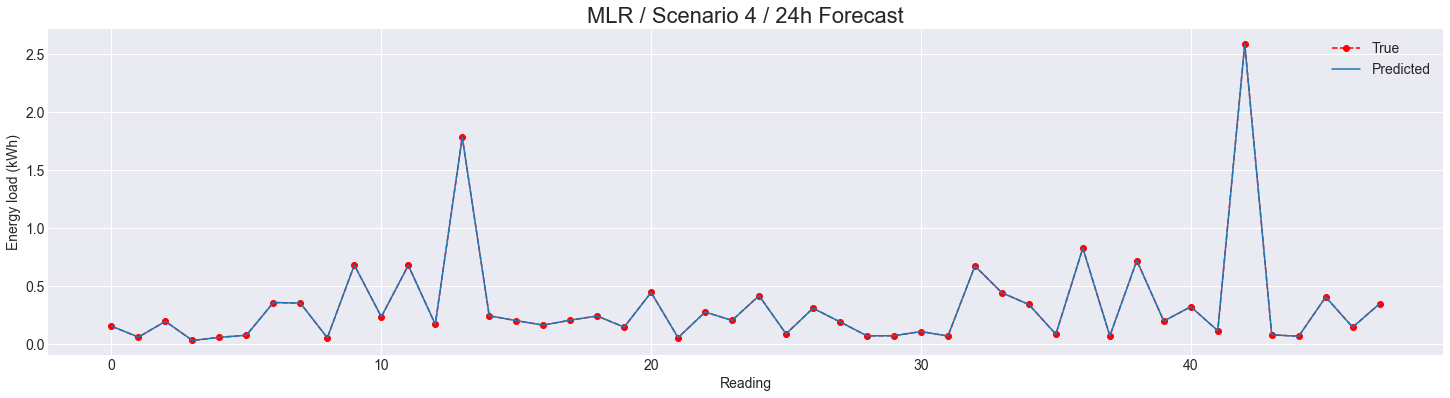

In [25]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 4 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [ ]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario4.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario4.joblib']

### support vector regressor (SVR)

SVM regressor, or SVR, works by  minimising the l2 norm, instead of the least square difference. The l2 norm is calculated as the square root of the sum of the squared vector values. Its main advantages are:

*   Effective in high dimensional spaces
*   Relatively memory efficient
*   Effective when there are more dimensions than samples

Disadvantages:
*   Not suitable when there is noise & overlapping
*   In cases where the number of features for each data point exceeds the number of training data samples, the SVM will underperform

Reference: https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2

https://dhirajkumarblog.medium.com/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107

https://machinelearningmastery.com/vector-norms-machine-learning/



In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [ ]:
#using linear SVR to reduce training time
model = LinearSVR(dual = False, #setting dual to False as there's more samples than features
                  loss='squared_epsilon_insensitive') 

C = [1e-7, 1e-5, 1e-3, 1e-1, 1.0, 4,8,12,14, 20] # regularization parameter
#kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
epsilon = [0.001, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]


# Parameters for tuning

param_grid = dict(C=C, epsilon=epsilon)

grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring='neg_mean_squared_error', cv=3, verbose=2)
# Get time before starting to fit the grid search
starting_time = time.time()
grid_result = grid.fit(train_X, train_y)
# Get time after finish, then calculate fitting time
end_time = time.time()
elapsed_time = end_time - starting_time
print('Fitting time:',elapsed_time)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV] C=1e-07, epsilon=0.001 ..........................................
[CV] ........................... C=1e-07, epsilon=0.001, total=   0.0s
[CV] C=1e-07, epsilon=0.001 ..........................................
[CV] ........................... C=1e-07, epsilon=0.001, total=   0.1s
[CV] C=1e-07, epsilon=0.001 ..........................................
[CV] ........................... C=1e-07, epsilon=0.001, total=   0.0s
[CV] C=1e-07, epsilon=0.01 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................ C=1e-07, epsilon=0.01, total=   0.1s
[CV] C=1e-07, epsilon=0.01 ...........................................
[CV] ............................ C=1e-07, epsilon=0.01, total=   0.1s
[CV] C=1e-07, epsilon=0.01 ...........................................
[CV] ............................ C=1e-07, epsilon=0.01, total=   0.0s
[CV] C=1e-07, epsilon=0.02 ...........................................
[CV] ............................ C=1e-07, epsilon=0.02, total=   0.1s
[CV] C=1e-07, epsilon=0.02 ...........................................
[CV] ............................ C=1e-07, epsilon=0.02, total=   0.1s
[CV] C=1e-07, epsilon=0.02 ...........................................
[CV] ............................ C=1e-07, epsilon=0.02, total=   0.1s
[CV] C=1e-07, epsilon=0.03 ...........................................
[CV] ............................ C=1e-07, epsilon=0.03, total=   0.1s
[CV] C=1e-07, epsilon=0.03 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:   37.5s finished


Fitting time: 38.081517457962036
Best: -0.000001 using {'C': 8, 'epsilon': 0.001}
-0.154789 (0.020762) with: {'C': 1e-07, 'epsilon': 0.001}
-0.154913 (0.020772) with: {'C': 1e-07, 'epsilon': 0.01}
-0.155049 (0.020783) with: {'C': 1e-07, 'epsilon': 0.02}
-0.155182 (0.020793) with: {'C': 1e-07, 'epsilon': 0.03}
-0.155432 (0.020813) with: {'C': 1e-07, 'epsilon': 0.05}
-0.155954 (0.020850) with: {'C': 1e-07, 'epsilon': 0.1}
-0.156669 (0.020889) with: {'C': 1e-07, 'epsilon': 0.2}
-0.099359 (0.013986) with: {'C': 1e-05, 'epsilon': 0.001}
-0.099239 (0.013931) with: {'C': 1e-05, 'epsilon': 0.01}
-0.099101 (0.013866) with: {'C': 1e-05, 'epsilon': 0.02}
-0.098959 (0.013800) with: {'C': 1e-05, 'epsilon': 0.03}
-0.098676 (0.013661) with: {'C': 1e-05, 'epsilon': 0.05}
-0.098095 (0.013354) with: {'C': 1e-05, 'epsilon': 0.1}
-0.099297 (0.014140) with: {'C': 1e-05, 'epsilon': 0.2}
-0.053842 (0.006357) with: {'C': 0.001, 'epsilon': 0.001}
-0.054297 (0.006313) with: {'C': 0.001, 'epsilon': 0.01}
-0.0548

In [27]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 0.237 s


**Prediction**

In [28]:
# make a prediction
yhat = model.predict(test_X)

In [29]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999994840416798
Mse:  0.000001002464658
Rmse: 0.001001231570738
Mae:  0.000737656920571
Mape:  0.487570938005260
Training time: 0.237 s


In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

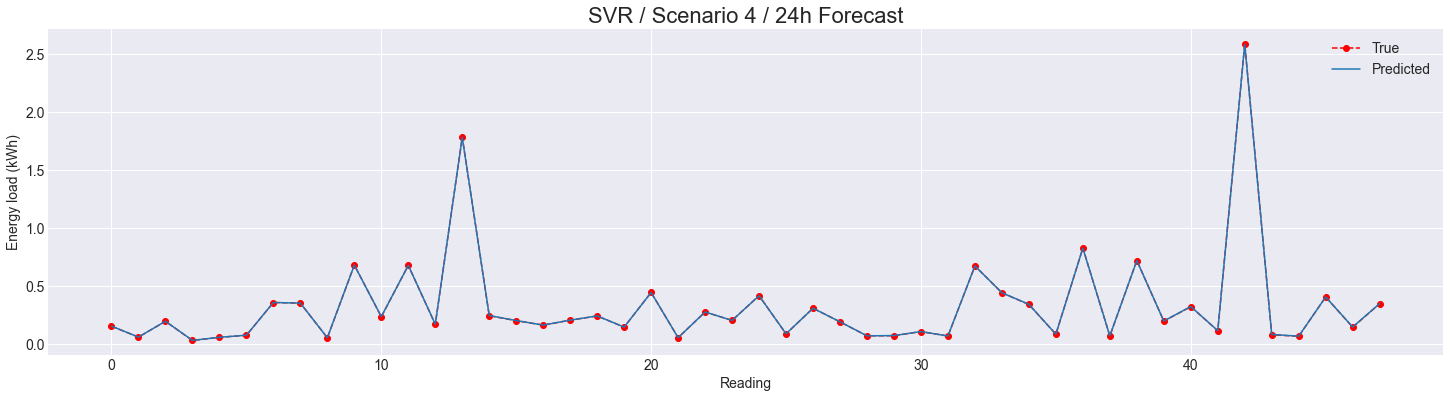

In [30]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 4 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_SVR.jpeg', dpi = 500)
plt.show()

Although the model picked up on the general trend, it clearly lacks the performance of the MLR.

In [ ]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario4.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario4.joblib']

### random forest (RF)

In [31]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(criterion='mse') #number of trees in the model

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['none', 10,0.33,0.2],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [8, 10, 12, 14],
    'n_estimators': [100, 200, 300]
}


#param_grid = dict(max_depth=max_depth)

grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring ='neg_mean_squared_error', cv=3, verbose=2)
# Get time before starting to fit the grid search
starting_time = time.time()
grid_result = grid.fit(train_X, train_y)
# Get time after finish, then calculate fitting time
end_time = time.time()
elapsed_time = end_time - starting_time
print('Fitting time:',elapsed_time)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.1s
[CV] bootstrap=True, max_depth=80, max_features=none, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, 

[Parallel(n_jobs=1)]: Done 2304 out of 2304 | elapsed: 791.2min finished


Fitting time: 47499.077781915665
Best: -0.002367 using {'bootstrap': True, 'max_depth': 110, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
nan (nan) with: {'bootstrap': True, 'max_depth': 80, 'max_features': 'none', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
nan (nan) with: {'bootstrap': True, 'max_depth': 80, 'max_features': 'none', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
nan (nan) with: {'bootstrap': True, 'max_depth': 80, 'max_features': 'none', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
nan (nan) with: {'bootstrap': True, 'max_depth': 80, 'max_features': 'none', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
nan (nan) with: {'bootstrap': True, 'max_depth': 80, 'max_features': 'none', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
nan (nan) with: {'bootstrap': True, 'max_depth': 80, 'max_features': 'none', 'min_samples_

In [32]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 26.204 s


**Prediction**

In [33]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [34]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.965787069513569
Mse:  0.005031842253502
Rmse: 0.070935479511328
Mae:  0.020369240830911
Mape:  6.228768342456380
Training time: 23.456 s


In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

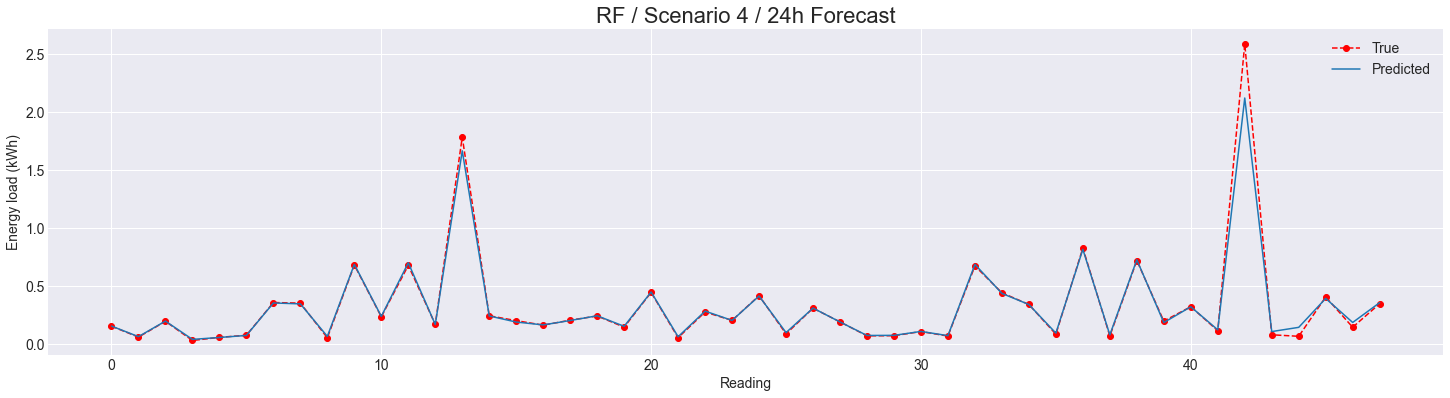

In [35]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 4 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_RF.jpeg', dpi = 500)
plt.show()

The model is predicting very well, picking up on very fine energy consumption trends

### feedforward neural networks (FFNNs)

Data must be reshaped for the neural networks models to work

In [36]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39480, 1, 43) (39480,) (48, 1, 43) (48,)


In [37]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [38]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [ ]:
def create_model(learn_rate = 0.01, momentum = 0.9, neurons1 = 32, neurons2 = 32):
	# create model
  model = Sequential()

  # Add fully connected layer with a ReLU activation function
  model.add(Dense(units=neurons1, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(units=neurons2, activation='relu'))
  # Add fully connected layer with no activation function
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=["accuracy"])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [5,10,15]
epochs = [8,10,12]
learn_rate = [0.01, 0.001, 0.0001]
momentum = [0.90, 0.95, 0.99]
neurons1 = [32,64,128]
neurons2 = [32,64,128]


param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate=learn_rate, momentum=momentum, neurons1= neurons1, neurons2=neurons2)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose = 2)
# Get time before starting to fit the grid search
starting_time = time.time()
grid_result = grid.fit(train_X, train_y)
# Get time after finish, then calculate fitting time
end_time = time.time()
elapsed_time = end_time - starting_time
print('Fitting time:',elapsed_time)
  
  # summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
     print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=32 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=32, total=  15.2s
[CV] batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=32 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV]  batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=32, total=  14.6s
[CV] batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=32 
[CV]  batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=32, total=  14.4s
[CV] batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=64 
[CV]  batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=64, total=  14.9s
[CV] batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=64 
[CV]  batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=64, total=  15.4s
[CV] batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=64 
[CV]  batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=64, total=  15.2s
[CV] batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neurons1=32, neurons2=128 
[CV]  batch_size=5, epochs=8, learn_rate=0.01, momentum=0.9, neu

[Parallel(n_jobs=1)]: Done 2187 out of 2187 | elapsed: 480.7min finished


Fitting time: 28853.435984373093
Best: 0.003470 using {'batch_size': 10, 'epochs': 8, 'learn_rate': 0.01, 'momentum': 0.95, 'neurons1': 128, 'neurons2': 32}
0.001520 (0.001721) with: {'batch_size': 5, 'epochs': 8, 'learn_rate': 0.01, 'momentum': 0.9, 'neurons1': 32, 'neurons2': 32}
0.001013 (0.000929) with: {'batch_size': 5, 'epochs': 8, 'learn_rate': 0.01, 'momentum': 0.9, 'neurons1': 32, 'neurons2': 64}
0.000101 (0.000036) with: {'batch_size': 5, 'epochs': 8, 'learn_rate': 0.01, 'momentum': 0.9, 'neurons1': 32, 'neurons2': 128}
0.000076 (0.000062) with: {'batch_size': 5, 'epochs': 8, 'learn_rate': 0.01, 'momentum': 0.9, 'neurons1': 64, 'neurons2': 32}
0.001165 (0.001542) with: {'batch_size': 5, 'epochs': 8, 'learn_rate': 0.01, 'momentum': 0.9, 'neurons1': 64, 'neurons2': 64}
0.001292 (0.000955) with: {'batch_size': 5, 'epochs': 8, 'learn_rate': 0.01, 'momentum': 0.9, 'neurons1': 64, 'neurons2': 128}
0.001317 (0.001756) with: {'batch_size': 5, 'epochs': 8, 'learn_rate': 0.01, 'momentu

In [40]:
from keras.optimizers import RMSprop

Epoch 1/10
7896/7896 - 4s - loss: 0.0075
Epoch 2/10
7896/7896 - 4s - loss: 8.1133e-04
Epoch 3/10
7896/7896 - 4s - loss: 4.4723e-04
Epoch 4/10
7896/7896 - 4s - loss: 3.1933e-04
Epoch 5/10
7896/7896 - 5s - loss: 2.5050e-04
Epoch 6/10
7896/7896 - 5s - loss: 2.0403e-04
Epoch 7/10
7896/7896 - 5s - loss: 1.7486e-04
Epoch 8/10
7896/7896 - 5s - loss: 1.5142e-04
Epoch 9/10
7896/7896 - 5s - loss: 1.3777e-04
Epoch 10/10
7896/7896 - 5s - loss: 1.2309e-04


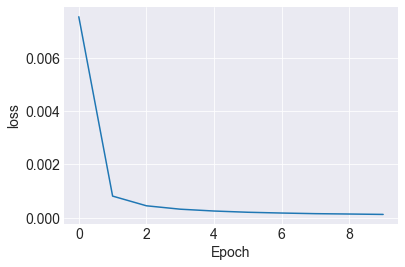

Training time: 45.104 s


In [41]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [42]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.998685889454680
Mse:  0.000258846692296
Rmse: 0.016088713195779
Mae:  0.015497377763192
Mape:  12.255682702972985
Training time: 43.698 s


In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

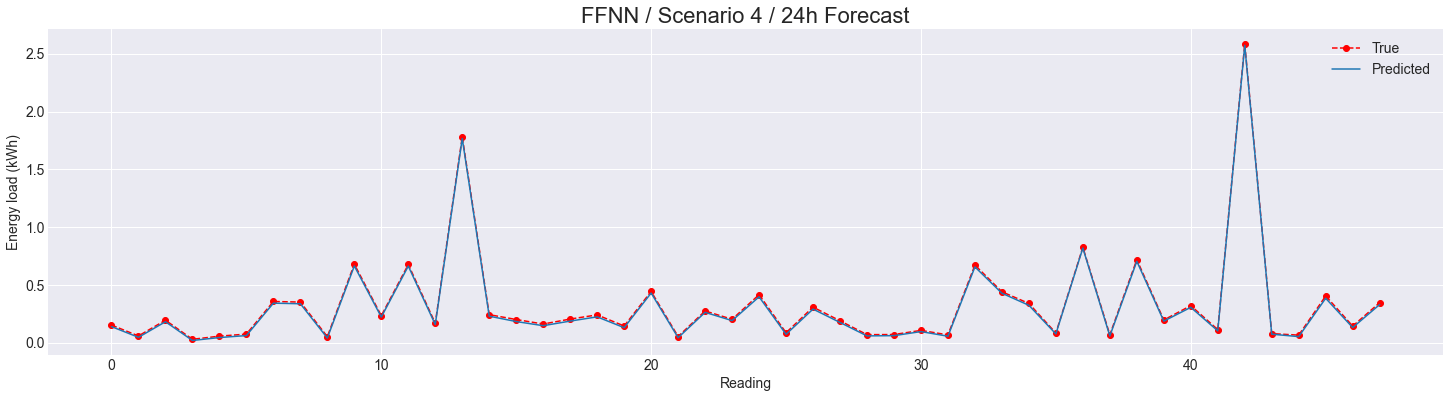

In [43]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 4 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

In [44]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [ ]:
np.random.seed(4) # fix random seed for reproducibility

def create_model(init_mode='uniform', neurons = 32, batch_size=24, epochs = 3, activation='relu',  optimizer='adam', learn_rate = 'none', momentum='none'):
  # create model
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), activation = activation))
  #model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=optimizer)  
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)

neurons = [32,64,128]
batch_size = [24,48,96]
epochs = [15,20,30]

learn_rate = [0.001, 0.0001]
momentum = [0.95, 0.99]
optimizer = ['SGD', 'RMSprop', 'Adam', 'Nadam']
activation = ['softmax', 'softplus', 'relu', 'tanh', 'sigmoid']

param_grid = dict(neurons=neurons,batch_size=batch_size, epochs=epochs,learn_rate=learn_rate, momentum = momentum, optimizer=optimizer, activation = activation )

grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=3, verbose=2)

# Get time before starting to fit the grid search
starting_time = time.time()
grid_result = grid.fit(train_X, train_y)
# Get time after finish, then calculate fitting time
end_time = time.time()
elapsed_time = end_time - starting_time
print('Fitting time:',elapsed_time)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits
[CV] activation=softmax, batch_size=24, epochs=15, learn_rate=0.001, momentum=0.95, neurons=32, optimizer=SGD 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=softmax, batch_size=24, epochs=15, learn_rate=0.001, momentum=0.95, neurons=32, optimizer=SGD, total=  12.2s
[CV] activation=softmax, batch_size=24, epochs=15, learn_rate=0.001, momentum=0.95, neurons=32, optimizer=SGD 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Adam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Adam, total=  24.9s
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam, total=  25.6s
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam, total=  25.7s
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam, total=  27.7s
[CV

[Parallel(n_jobs=1)]: Done 6480 out of 6480 | elapsed: 1923.1min finished


Fitting time: 115426.90352249146
Best: -0.000003 using {'activation': 'softplus', 'batch_size': 24, 'epochs': 30, 'learn_rate': 0.0001, 'momentum': 0.99, 'neurons': 128, 'optimizer': 'Adam'}
-0.097013 (0.010423) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'SGD'}
-0.001183 (0.000606) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'RMSprop'}
-0.000774 (0.000497) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'Adam'}
-0.000757 (0.000497) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'Nadam'}
-0.097017 (0.010735) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 64, 'optimizer': 'SGD'}
-0.0011

In [45]:
from keras.optimizers import Adam

Epoch 1/30
1645/1645 - 2s - loss: 0.0361
Epoch 2/30
1645/1645 - 2s - loss: 0.0014
Epoch 3/30
1645/1645 - 2s - loss: 0.0016
Epoch 4/30
1645/1645 - 2s - loss: 0.0020
Epoch 5/30
1645/1645 - 2s - loss: 8.9950e-04
Epoch 6/30
1645/1645 - 2s - loss: 9.9366e-04
Epoch 7/30
1645/1645 - 2s - loss: 0.0015
Epoch 8/30
1645/1645 - 2s - loss: 3.6329e-04
Epoch 9/30
1645/1645 - 2s - loss: 0.0011
Epoch 10/30
1645/1645 - 2s - loss: 8.5552e-04
Epoch 11/30
1645/1645 - 2s - loss: 7.1568e-04
Epoch 12/30
1645/1645 - 2s - loss: 6.9897e-04
Epoch 13/30
1645/1645 - 2s - loss: 8.7909e-04
Epoch 14/30
1645/1645 - 2s - loss: 7.8764e-04
Epoch 15/30
1645/1645 - 2s - loss: 4.2282e-04
Epoch 16/30
1645/1645 - 2s - loss: 4.0846e-04
Epoch 17/30
1645/1645 - 2s - loss: 6.6571e-04
Epoch 18/30
1645/1645 - 1s - loss: 6.3592e-04
Epoch 19/30
1645/1645 - 2s - loss: 3.8000e-04
Epoch 20/30
1645/1645 - 2s - loss: 5.0767e-04
Epoch 21/30
1645/1645 - 2s - loss: 1.3341e-04
Epoch 22/30
1645/1645 - 2s - loss: 7.2632e-04
Epoch 23/30
1645/1645

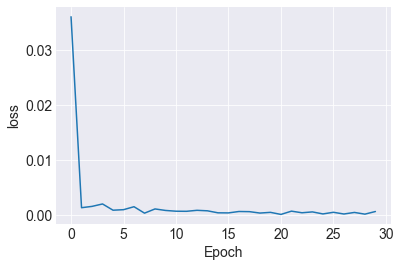

Training time: 51.985 s


In [46]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [47]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999749818911620
Mse:  0.000048883010937
Rmse: 0.006991638644633
Mae:  0.006457756506279
Mape:  4.109426849795444
Training time: 50.653 s


In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

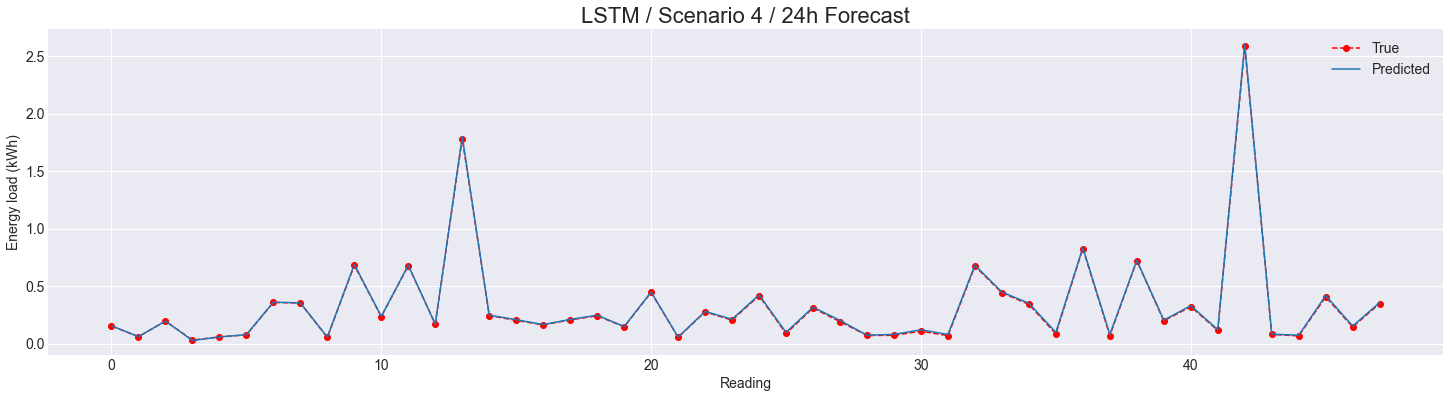

In [48]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 4 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [49]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
np.random.seed(5) # fix random seed for reproducibility


def create_model(init_mode='uniform', neurons = 32, batch_size=24, epochs = 3, activation='relu',  optimizer='adam', learn_rate = 'none', momentum='none'):
  # create model
  model = Sequential()
  model.add(SimpleRNN(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), activation = activation))
  #model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=optimizer)  
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)

neurons = [32,64,128]
batch_size = [24,48,96]
epochs = [15,20,30]

learn_rate = [0.001, 0.0001]
momentum = [0.95, 0.99]
optimizer = ['SGD', 'RMSprop', 'Adam', 'Nadam']
activation = ['softmax', 'softplus', 'relu', 'tanh', 'sigmoid']

param_grid = dict(neurons=neurons,batch_size=batch_size, epochs=epochs,learn_rate=learn_rate, momentum = momentum, optimizer=optimizer, activation = activation )



grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=3, verbose=2)
# Get time before starting to fit the grid search
starting_time = time.time()
grid_result = grid.fit(train_X, train_y)
# Get time after finish, then calculate fitting time
end_time = time.time()
elapsed_time = end_time - starting_time
print('Fitting time:',elapsed_time)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits
[CV] activation=softmax, batch_size=24, epochs=15, learn_rate=0.001, momentum=0.95, neurons=32, optimizer=SGD 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=softmax, batch_size=24, epochs=15, learn_rate=0.001, momentum=0.95, neurons=32, optimizer=SGD, total=  11.7s
[CV] activation=softmax, batch_size=24, epochs=15, learn_rate=0.001, momentum=0.95, neurons=32, optimizer=SGD 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Adam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Adam, total=  14.8s
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam, total=  14.9s
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam, total=  15.6s
[CV] activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam 
[CV]  activation=tanh, batch_size=24, epochs=15, learn_rate=0.0001, momentum=0.95, neurons=64, optimizer=Nadam, total=  16.1s
[CV

[Parallel(n_jobs=1)]: Done 6480 out of 6480 | elapsed: 1339.4min finished


Fitting time: 80392.0120253563
Best: -0.000007 using {'activation': 'relu', 'batch_size': 24, 'epochs': 30, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'Adam'}
-0.093794 (0.010484) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'SGD'}
-0.001053 (0.000466) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'RMSprop'}
-0.000736 (0.000457) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'Adam'}
-0.000691 (0.000401) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 32, 'optimizer': 'Nadam'}
-0.096456 (0.010864) with: {'activation': 'softmax', 'batch_size': 24, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons': 64, 'optimizer': 'SGD'}
-0.001239 (0.00

Epoch 1/30
1645/1645 - 1s - loss: 0.0238
Epoch 2/30
1645/1645 - 1s - loss: 0.0020
Epoch 3/30
1645/1645 - 1s - loss: 0.0017
Epoch 4/30
1645/1645 - 1s - loss: 0.0057
Epoch 5/30
1645/1645 - 1s - loss: 7.0792e-04
Epoch 6/30
1645/1645 - 1s - loss: 5.5284e-04
Epoch 7/30
1645/1645 - 1s - loss: 9.9048e-04
Epoch 8/30
1645/1645 - 1s - loss: 0.0015
Epoch 9/30
1645/1645 - 1s - loss: 0.0016
Epoch 10/30
1645/1645 - 1s - loss: 2.8258e-04
Epoch 11/30
1645/1645 - 1s - loss: 6.6578e-04
Epoch 12/30
1645/1645 - 1s - loss: 8.7736e-04
Epoch 13/30
1645/1645 - 1s - loss: 4.6336e-04
Epoch 14/30
1645/1645 - 1s - loss: 5.5261e-04
Epoch 15/30
1645/1645 - 1s - loss: 3.8810e-04
Epoch 16/30
1645/1645 - 1s - loss: 2.9656e-04
Epoch 17/30
1645/1645 - 1s - loss: 2.8651e-04
Epoch 18/30
1645/1645 - 1s - loss: 4.0569e-04
Epoch 19/30
1645/1645 - 1s - loss: 3.6409e-04
Epoch 20/30
1645/1645 - 1s - loss: 2.1328e-04
Epoch 21/30
1645/1645 - 1s - loss: 2.7845e-04
Epoch 22/30
1645/1645 - 1s - loss: 3.1806e-04
Epoch 23/30
1645/1645

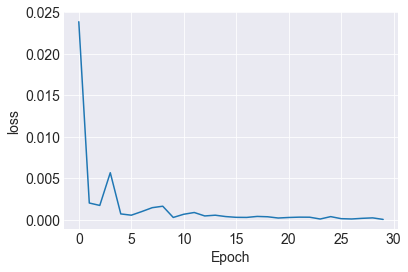

Training time: 37.510 s


In [ ]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [51]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999213238563524
Mse:  0.000159769228360
Rmse: 0.012639985299053
Mae:  0.006766660565821
Mape:  3.787187460173212
Training time: 37.510 s


In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

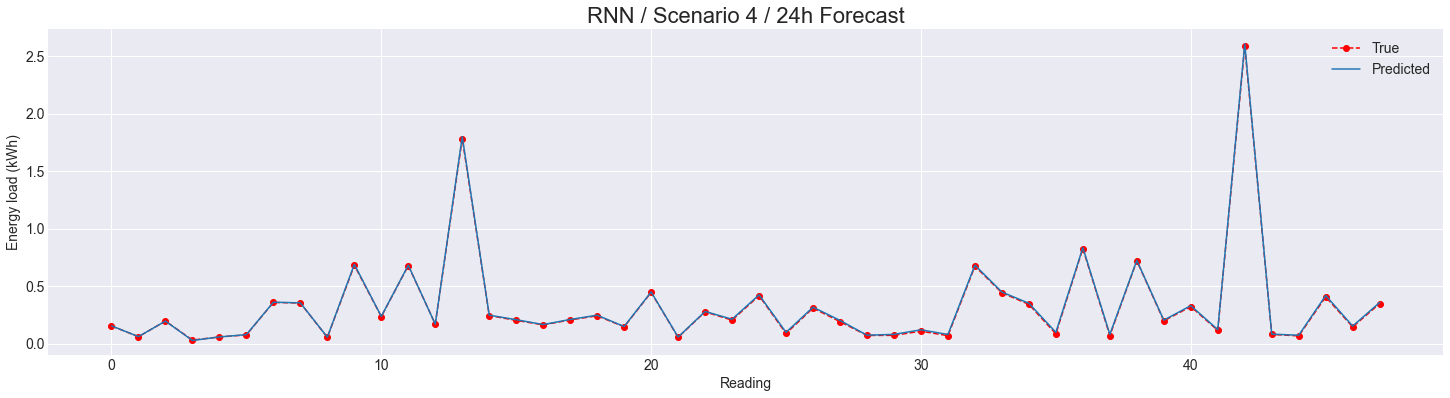

In [52]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 4 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_RNN.jpeg', dpi = 500)
plt.show()

The model is doing well however its accuracy is worse than that of CNN-LSTM. However, it's training 4 times faster. 

Because this model achieved the best performance, saving it:

### Dense + LSTM

In Masterarbeit to fully leverage the neural network achitecture, an LSTM layer is combined with two dense ones. 

In [ ]:
def create_model(init_mode='uniform', neurons1 = 64, neurons2 = 64, neurons_LSTM = 32, activation='relu',  learn_rate = 'none', momentum='none'):
	# create model
  model = Sequential()
  model.add(Dense(neurons1, activation=activation,  input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(neurons2, activation=activation))
  model.add(LSTM(neurons_LSTM))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
  return model


model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters


neurons1 = [64,128, 256]
neurons2 = [64,128, 256]
neurons_LSTM = [32,64,128]
batch_size = [64,128]
epochs = [15, 30]
learn_rate = [0.001, 0.0001]
momentum = [0.95, 0.99]
activation = ['relu']

  # define the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs, neurons1 = neurons1, neurons2 = neurons2,  neurons_LSTM = neurons_LSTM,
                  learn_rate=learn_rate, momentum = momentum, activation = activation)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)

# Get time before starting to fit the grid search
starting_time = time.time()
grid_result = grid.fit(train_X, train_y)
# Get time after finish, then calculate fitting time
end_time = time.time()
elapsed_time = end_time - starting_time
print('Fitting time:',elapsed_time)
  
  # summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
     print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=32 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=32, total=   9.2s
[CV] activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=32 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV]  activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=32, total=   8.8s
[CV] activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=32 
[CV]  activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=32, total=   9.1s
[CV] activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=64 
[CV]  activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=64, total=  10.0s
[CV] activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=64 
[CV]  activation=relu, batch_size=64, epochs=15, learn_rate=0.001, momentum=0.95, neurons1=64, neurons2=64, neurons_LSTM=64, total=   9.7s
[CV] activation=relu, batch_size=64, epochs=15, learn_rate=0.001, moment

[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 314.3min finished


Fitting time: 18895.13079714775
Best: 0.003166 using {'activation': 'relu', 'batch_size': 64, 'epochs': 30, 'learn_rate': 0.0001, 'momentum': 0.95, 'neurons1': 256, 'neurons2': 64, 'neurons_LSTM': 128}
0.000076 (0.000062) with: {'activation': 'relu', 'batch_size': 64, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons1': 64, 'neurons2': 64, 'neurons_LSTM': 32}
0.000076 (0.000062) with: {'activation': 'relu', 'batch_size': 64, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons1': 64, 'neurons2': 64, 'neurons_LSTM': 64}
0.000177 (0.000129) with: {'activation': 'relu', 'batch_size': 64, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons1': 64, 'neurons2': 64, 'neurons_LSTM': 128}
0.000076 (0.000062) with: {'activation': 'relu', 'batch_size': 64, 'epochs': 15, 'learn_rate': 0.001, 'momentum': 0.95, 'neurons1': 64, 'neurons2': 128, 'neurons_LSTM': 32}
0.000076 (0.000062) with: {'activation': 'relu', 'batch_size': 64, 'epochs': 15, 'learn_rate': 0.001, 'momen

Epoch 1/30
617/617 - 1s - loss: 0.0832
Epoch 2/30
617/617 - 1s - loss: 0.0397
Epoch 3/30
617/617 - 1s - loss: 0.0026
Epoch 4/30
617/617 - 1s - loss: 9.8350e-04
Epoch 5/30
617/617 - 1s - loss: 8.0573e-04
Epoch 6/30
617/617 - 2s - loss: 7.4215e-04
Epoch 7/30
617/617 - 1s - loss: 7.0922e-04
Epoch 8/30
617/617 - 1s - loss: 6.8163e-04
Epoch 9/30
617/617 - 1s - loss: 5.8222e-04
Epoch 10/30
617/617 - 1s - loss: 5.9137e-04
Epoch 11/30
617/617 - 1s - loss: 5.1700e-04
Epoch 12/30
617/617 - 1s - loss: 5.3593e-04
Epoch 13/30
617/617 - 1s - loss: 4.6003e-04
Epoch 14/30
617/617 - 1s - loss: 5.0052e-04
Epoch 15/30
617/617 - 1s - loss: 4.0602e-04
Epoch 16/30
617/617 - 1s - loss: 4.7843e-04
Epoch 17/30
617/617 - 1s - loss: 3.5529e-04
Epoch 18/30
617/617 - 1s - loss: 4.3611e-04
Epoch 19/30
617/617 - 1s - loss: 3.2810e-04
Epoch 20/30
617/617 - 1s - loss: 3.9952e-04
Epoch 21/30
617/617 - 1s - loss: 3.0118e-04
Epoch 22/30
617/617 - 1s - loss: 3.6521e-04
Epoch 23/30
617/617 - 1s - loss: 2.9021e-04
Epoch 24/

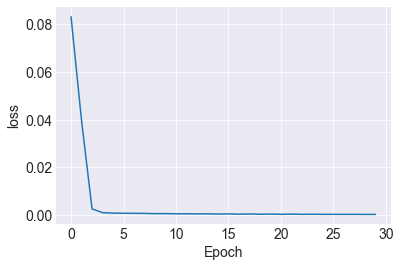

Training time: 42.349 s


In [53]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [ ]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario4_24h.h5')

**Prediction**

In [54]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.996679395761174
Mse:  0.000633735947067
Rmse: 0.025174112637127
Mae:  0.020860094965125
Mape:  14.542172962834854
Training time: 36.912 s


In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

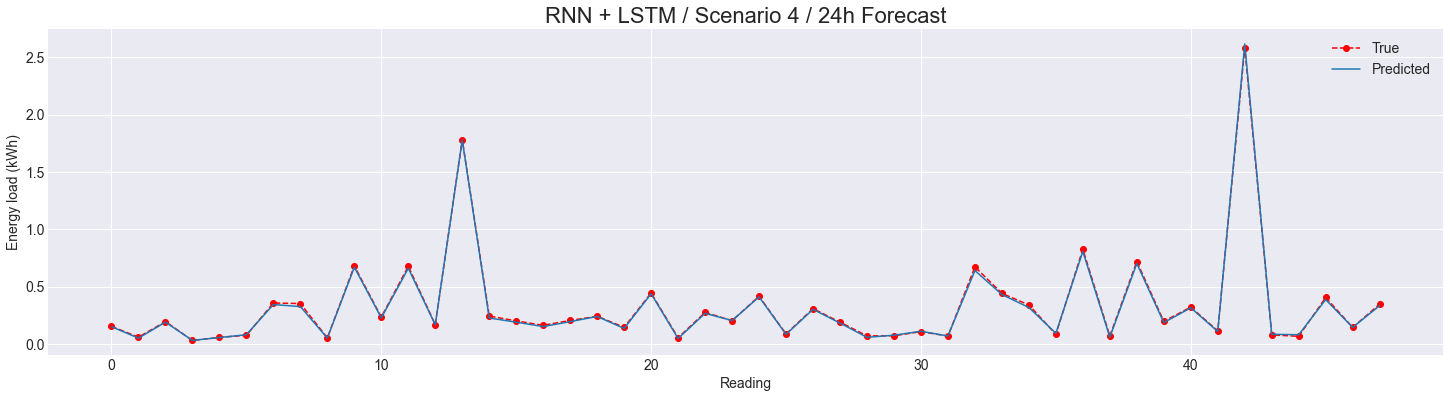

In [55]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 4 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.

### Best model

In [ ]:
models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
                                   columns=models_predictions, 
                                   index=['R2_scores', 'MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores', 'Train_Time'])
models_performances

MLR       SVM         RF      FFNNs       LSTM  \
R2_scores    1.000000e+00  0.999995   0.965787   0.998686   0.999750   
MSE_scores   1.034461e-16  0.000001   0.005032   0.000259   0.000049   
RMSE_scores  1.017084e-08  0.001001   0.070935   0.016089   0.006992   
MAE_scores   6.226212e-09  0.000738   0.020369   0.015497   0.006458   
MAPE_scores  1.986237e-06  0.487571   6.228768  12.255683   4.109427   
Train_Time   4.089189e-02  0.219440  23.456307  43.697770  50.653464   

                   RNN  Dense+LSTM  
R2_scores     0.999213    0.996679  
MSE_scores    0.000160    0.000634  
RMSE_scores   0.012640    0.025174  
MAE_scores    0.006767    0.020860  
MAPE_scores   3.787187   14.542173  
Train_Time   37.510172   36.911555

In [ ]:
models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario4.csv', index=False)

Most models are returning similar scores, except for the SVM, which is significantly under-performing. 

The best performance, in terms of all the metrics measured except for training time, is the neural network with dense layers combined with LSTM.

**Plotting all models together.**

In [56]:
prev_day = train_y[-48:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [57]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [58]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv').time)[-96:]

In [59]:
prev_2days

['2014-02-26 00:30:00',
 '2014-02-26 01:00:00',
 '2014-02-26 01:30:00',
 '2014-02-26 02:00:00',
 '2014-02-26 02:30:00',
 '2014-02-26 03:00:00',
 '2014-02-26 03:30:00',
 '2014-02-26 04:00:00',
 '2014-02-26 04:30:00',
 '2014-02-26 05:00:00',
 '2014-02-26 05:30:00',
 '2014-02-26 06:00:00',
 '2014-02-26 06:30:00',
 '2014-02-26 07:00:00',
 '2014-02-26 07:30:00',
 '2014-02-26 08:00:00',
 '2014-02-26 08:30:00',
 '2014-02-26 09:00:00',
 '2014-02-26 09:30:00',
 '2014-02-26 10:00:00',
 '2014-02-26 10:30:00',
 '2014-02-26 11:00:00',
 '2014-02-26 11:30:00',
 '2014-02-26 12:00:00',
 '2014-02-26 12:30:00',
 '2014-02-26 13:00:00',
 '2014-02-26 13:30:00',
 '2014-02-26 14:00:00',
 '2014-02-26 14:30:00',
 '2014-02-26 15:00:00',
 '2014-02-26 15:30:00',
 '2014-02-26 16:00:00',
 '2014-02-26 16:30:00',
 '2014-02-26 17:00:00',
 '2014-02-26 17:30:00',
 '2014-02-26 18:00:00',
 '2014-02-26 18:30:00',
 '2014-02-26 19:00:00',
 '2014-02-26 19:30:00',
 '2014-02-26 20:00:00',
 '2014-02-26 20:30:00',
 '2014-02-26 21:

In [60]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

In [61]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [62]:
# Fill in with corresponding values
df_for_plotting["Train"][:-48] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-48:] = model_pred

In [63]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [64]:
df_for_plotting.columns

Index(['Original', 'Train', 'MLR forecast', 'SVR forecast', 'RF forecast',
       'FFNN forecast', 'LSTM forecast', 'RNN forecast',
       'Dense-LSTM forecast'],
      dtype='object')

In [65]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

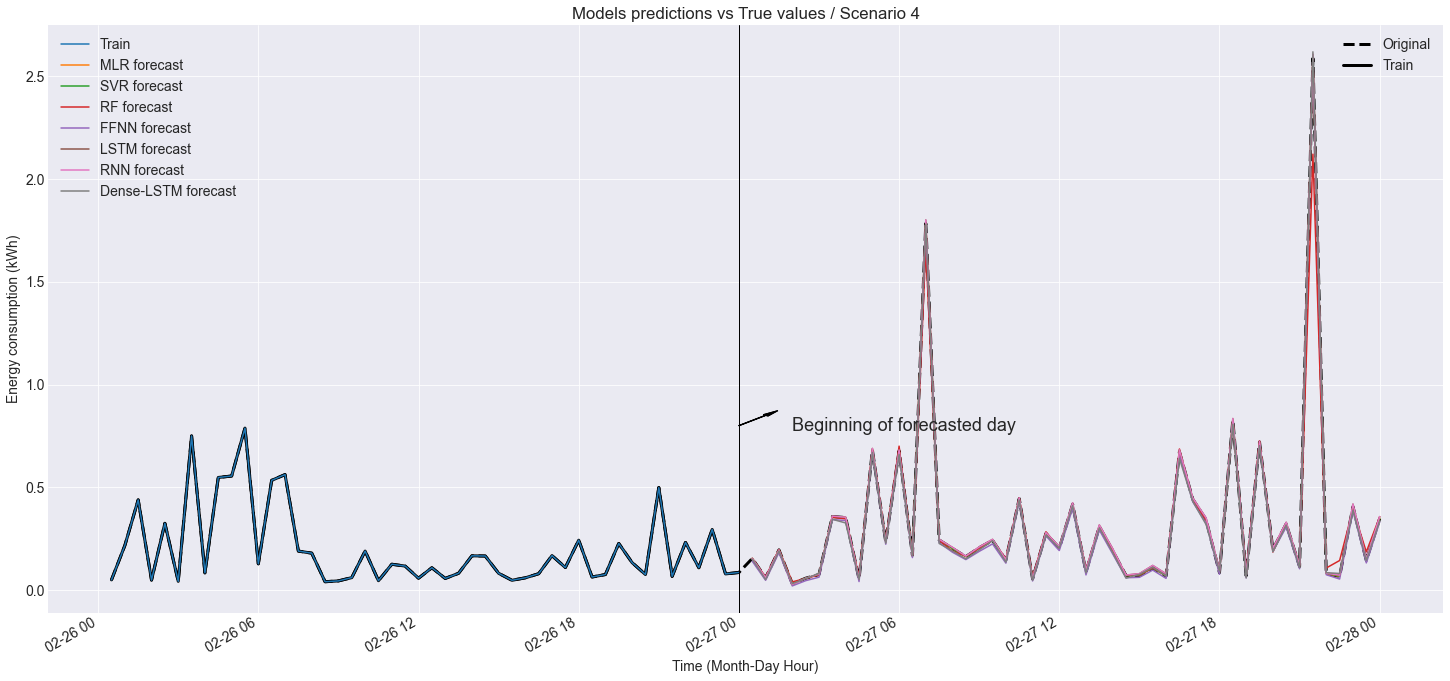

In [69]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)


# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='K', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[1:]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)


# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.8, dx, 0.05, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)


plt.title('Models predictions vs True values / Scenario 4')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_OriginalPredicted_All.jpeg', dpi = 500)
plt.show()

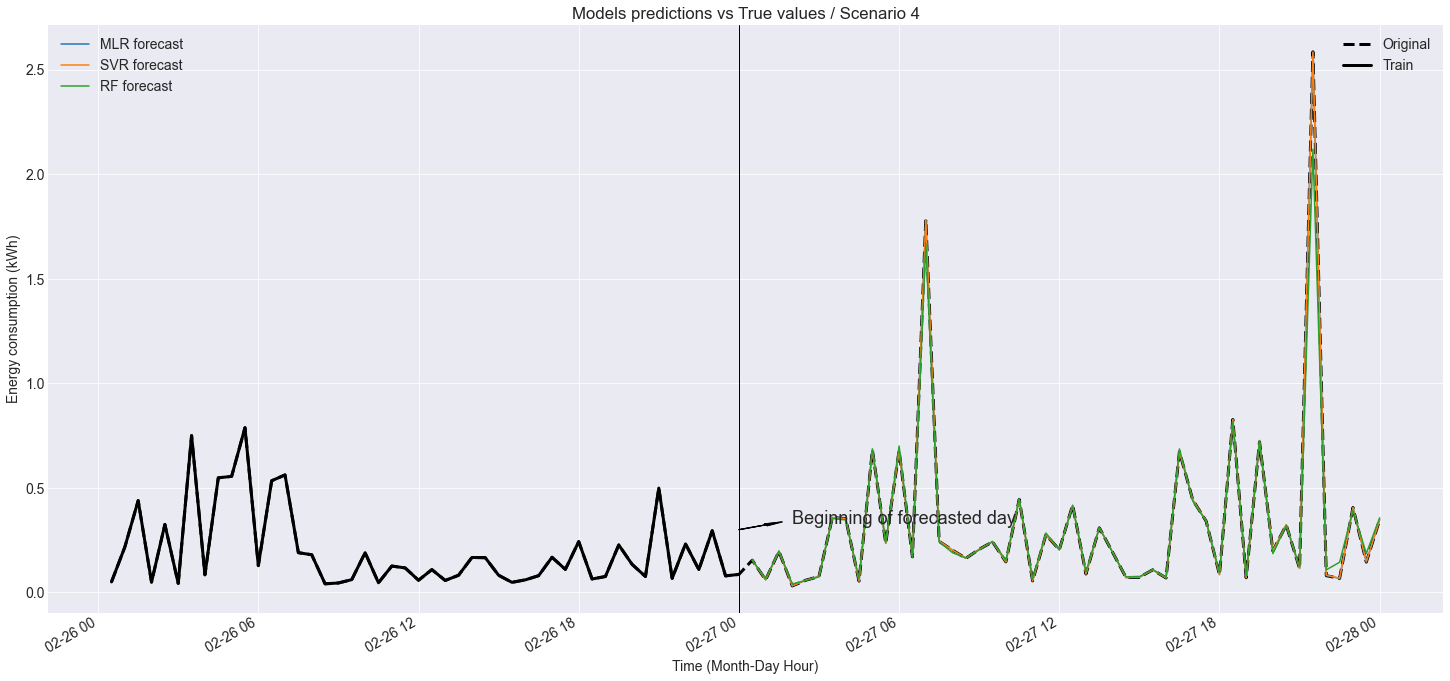

In [70]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[2:5]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.35, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.3, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Models predictions vs True values / Scenario 4')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_RegressionModelsPredicted_All.jpeg', dpi = 500)
plt.show()

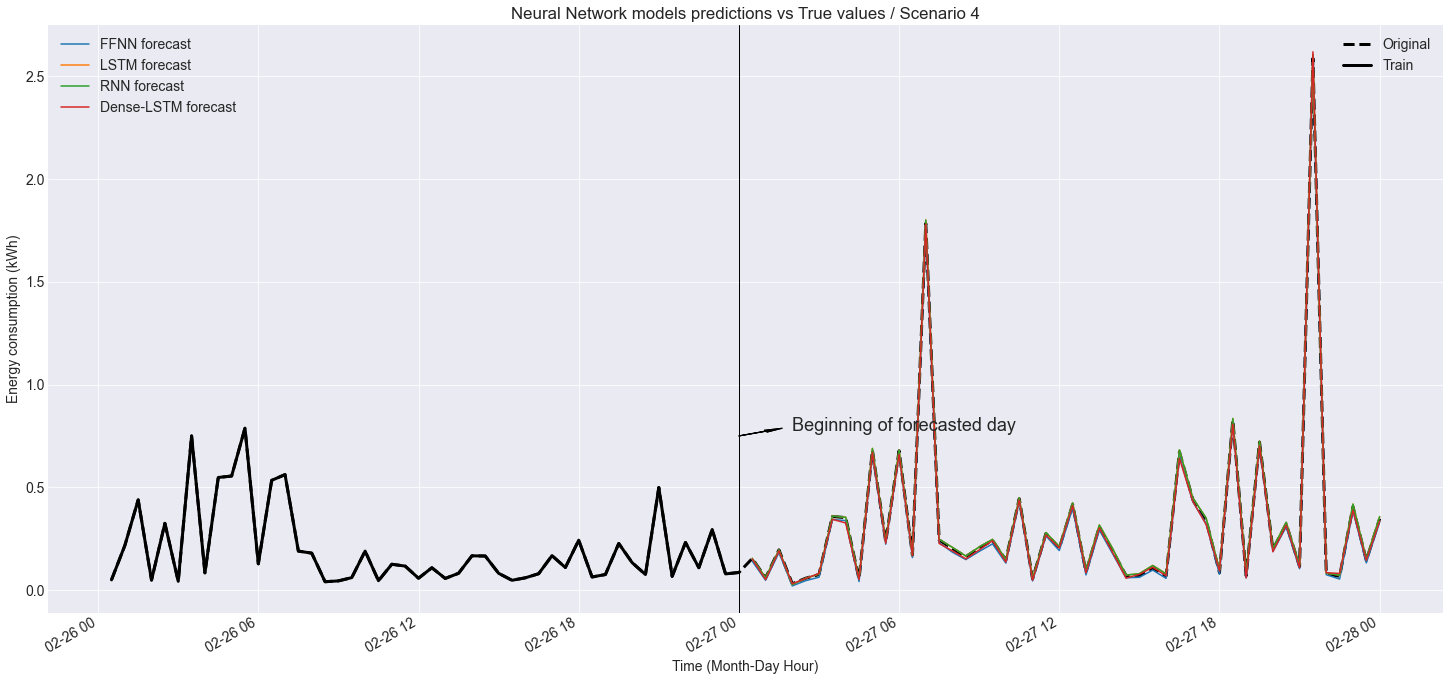

In [71]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[5:]:
  df_for_plotting[forecast].plot()

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.75, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Neural Network models predictions vs True values / Scenario 4')
plt.legend(loc='upper left')
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/1_allHouseholds/S4_24h_OriginalPredicted_4_8.jpeg', dpi = 500)
plt.show()

## House level prediction 
-For each half hour, for each of the 33 types.

In [72]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [ ]:
houses_data

LCLid                 tstp  energy(kWh/hh)
0            2  2012-10-12 00:30:00           0.000
1            2  2012-10-12 01:00:00           0.000
2            2  2012-10-12 01:30:00           0.000
3            2  2012-10-12 02:00:00           0.000
4            2  2012-10-12 02:30:00           0.000
...        ...                  ...             ...
8092712   5124  2014-02-27 22:00:00           0.673
8092713   5124  2014-02-27 22:30:00           0.590
8092714   5124  2014-02-27 23:00:00           0.552
8092715   5124  2014-02-27 23:30:00           0.519
8092716   5124  2014-02-28 00:00:00           0.390

[8092717 rows x 3 columns]

In [73]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [74]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [75]:
weather_energy.columns[1:]

Index(['year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [76]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [77]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'stdorToU', 'Acorn',
       'Acorn_grouped', 'weekend'],
      dtype='object')

In [78]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'stdorToU', 'Acorn',
       'Acorn_grouped', 'weekend']

In [79]:
updated_houses

LCLid                 time  energy(kWh/hh)_x  year  month  day  hour  \
0            2  2012-10-12 00:30:00             0.000  2012     10   12     0   
1          246  2012-10-12 00:30:00             0.975  2012     10   12     0   
2         1074  2012-10-12 00:30:00             1.438  2012     10   12     0   
3         3281  2012-10-12 00:30:00             0.078  2012     10   12     0   
4         3305  2012-10-12 00:30:00             0.101  2012     10   12     0   
...        ...                  ...               ...   ...    ...  ...   ...   
8086036    183  2011-12-03 06:30:00             0.109  2011     12    3     6   
8086037    183  2011-12-03 07:00:00             0.030  2011     12    3     7   
8086038    183  2011-12-03 07:30:00             0.082  2011     12    3     7   
8086039    183  2011-12-03 08:00:00             0.030  2011     12    3     8   
8086040    183  2011-12-03 08:30:00             0.365  2011     12    3     8   

         weekday  energy(kWh/hh)_y  visibility  ...  dewPoint  pressure  \
0              4             0.135       11.76  ...     12.21    999.47   
1              4             0.135       11.76  ...     12.21    999.47   
2              4             0.135       11.76  ...     12.21    999.47   
3              4             0.135       11.76  ...     12.21    999.47   
4              4             0.135       11.76  ...     12.21    999.47   
...          ...               ...         ...  ...       ...       ...   
8086036        5             0.109       11.73  ...     10.26   1001.07   
8086037        5             0.030       11.93  ...      9.73   1001.07   
8086038        5             0.082       11.93  ...      9.73   1001.07   
8086039        5             0.030       13.71  ...      9.11   1001.55   
8086040        5             0.365       13.71  ...      9.11   1001.55   

         apparentTemperature  windSpeed  humidity  holiday_ind  stdorToU  \
0                      13.61       5.40      0.91            0         0   
1                      13.61       5.40      0.91            0         0   
2                      13.61       5.40      0.91            0         0   
3                      13.61       5.40      0.91            0         0   
4                      13.61       5.40      0.91            0         0   
...                      ...        ...       ...          ...       ...   
8086036                11.00       6.37      0.95            0         0   
8086037                10.96       5.48      0.92            0         0   
8086038                10.96       5.48      0.92            0         0   
8086039                11.01       6.32      0.88            0         0   
8086040                11.01       6.32      0.88            0         0   

         Acorn  Acorn_grouped  weekend  
0           10              4        0  
1           10              4        0  
2           10              4        0  
3           10              4        0  
4           10              4        0  
...        ...            ...      ...  
8086036      7              4        1  
8086037      7              4        1  
8086038      7              4        1  
8086039      7              4        1  
8086040      7              4        1  

[8086041 rows x 22 columns]

In [ ]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S4.csv')

In [80]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S4.csv')

In [81]:
updated_houses.columns

Index(['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month',
       'day', 'hour', 'weekday', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [82]:
updated_houses.columns = ['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'year', 'month',
       'day', 'hour', 'weekday', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend']

In [83]:
updated_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8086041 entries, 0 to 8086040
Data columns (total 23 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   LCLid                int64  
 2   time                 object 
 3   energy(kWh/hh)       float64
 4   year                 int64  
 5   month                int64  
 6   day                  int64  
 7   hour                 int64  
 8   weekday              int64  
 9   energy(kWh/hh)_y     float64
 10  visibility           float64
 11  windBearing          int64  
 12  temperature          float64
 13  dewPoint             float64
 14  pressure             float64
 15  apparentTemperature  float64
 16  windSpeed            float64
 17  humidity             float64
 18  holiday_ind          int64  
 19  stdorToU             int64  
 20  Acorn                int64  
 21  Acorn_grouped        int64  
 22  weekend              int64  
dtypes: float64(9), int64(13), object

In [84]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

Function to check another household:

In [85]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [86]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))




  model = Sequential()
  model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /RNN (Scenario 4)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/2_singleHouseholdLevel/best_NN_model/S4_24h_RNN_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


In [87]:
from keras.optimizers import Adam

Mse:  5065.364831567601868
Rmse: 71.171376490606121
Mae:  71.126304846412197
Mape:  99.759986031603916


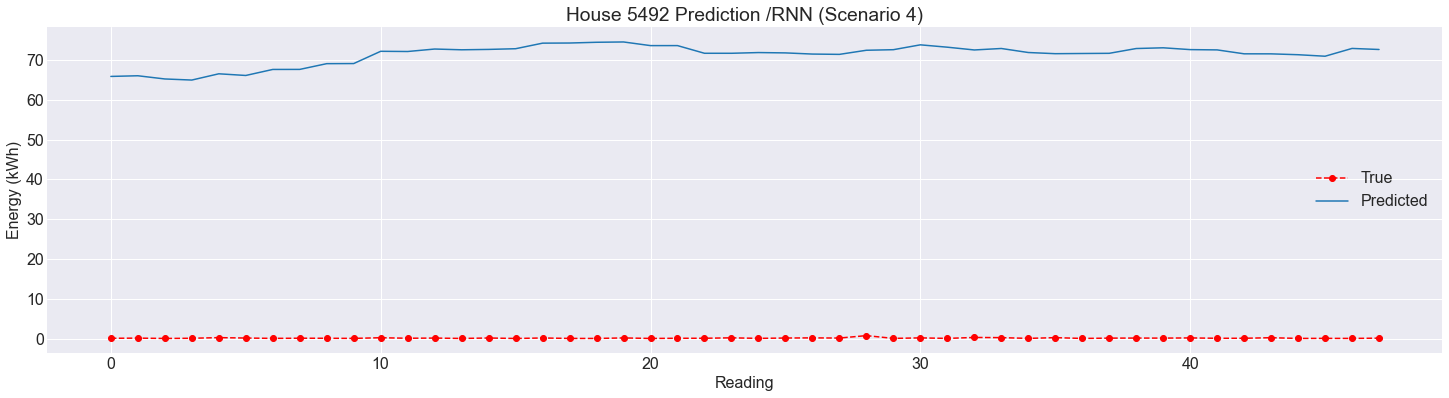

Mse:  152082.635595722618746
Rmse: 389.977737307814323
Mae:  389.976054344015836
Mape:  99.937412034129864


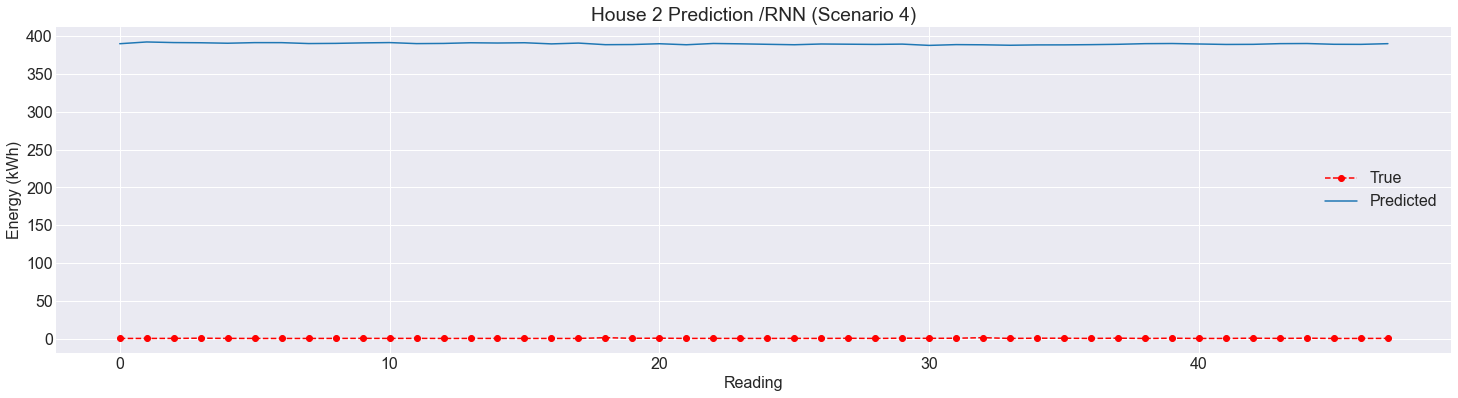

Mse:  1646.455527152694458
Rmse: 40.576539122412775
Mae:  40.488022958549358
Mape:  101.782057830135585


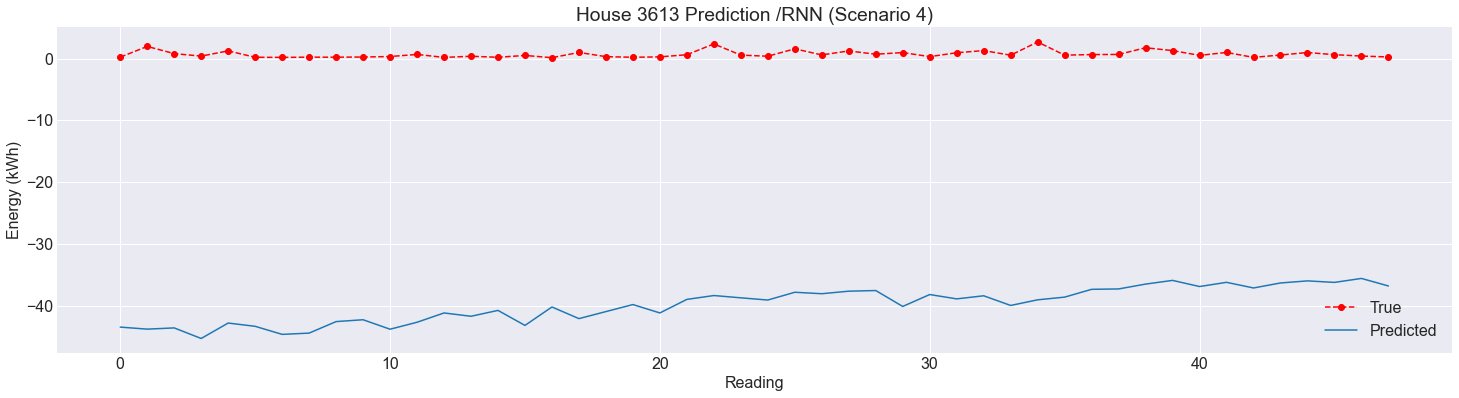

Mse:  147725.525974556076108
Rmse: 384.350785057811606
Mae:  384.348455860434740
Mape:  100.038012099237903


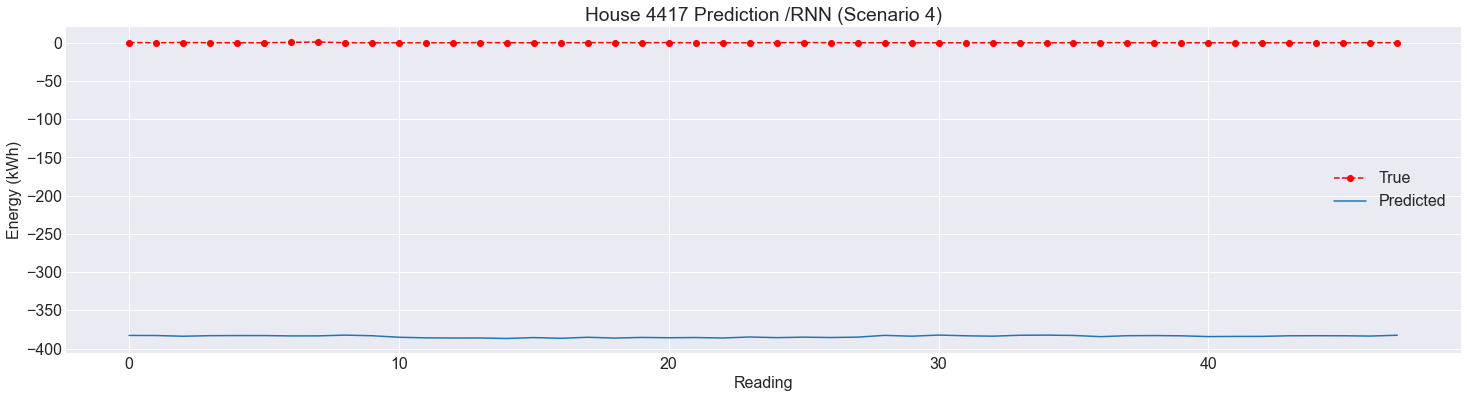

Mse:  1956.331333820137615
Rmse: 44.230434474693297
Mae:  44.164378054966313
Mape:  99.853884900601031


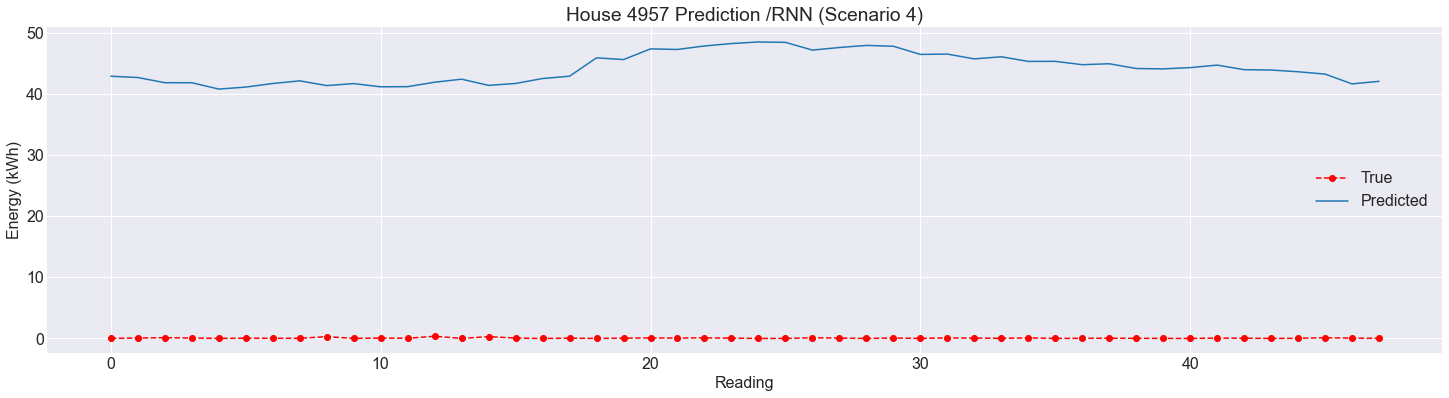

Mse:  12223.893835787806893
Rmse: 110.561719576840005
Mae:  110.470300225385770
Mape:  100.147439287551904


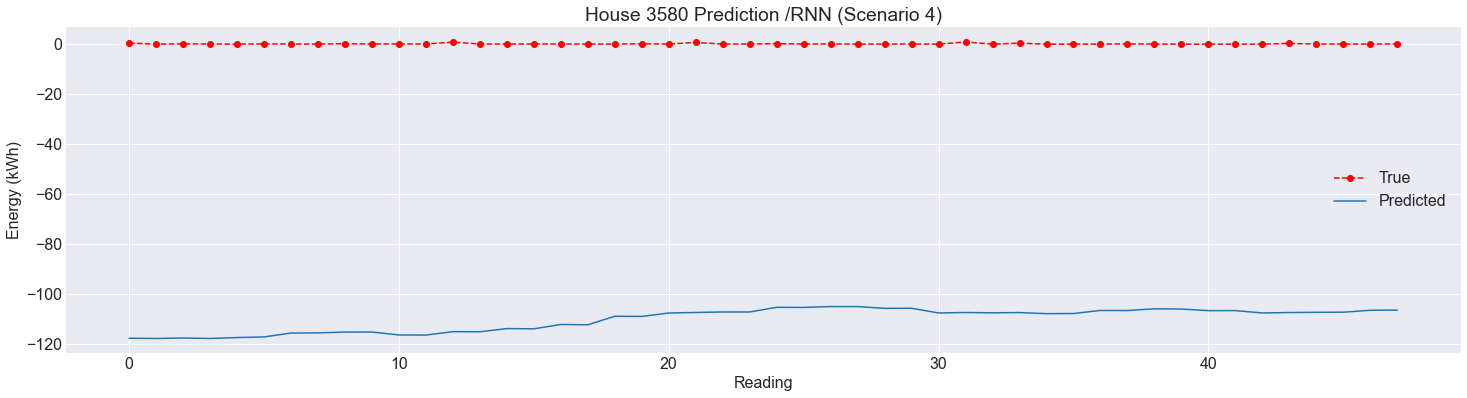

Mse:  6868.470850356444316
Rmse: 82.876238152780829
Mae:  82.826941826458395
Mape:  99.579697595403786


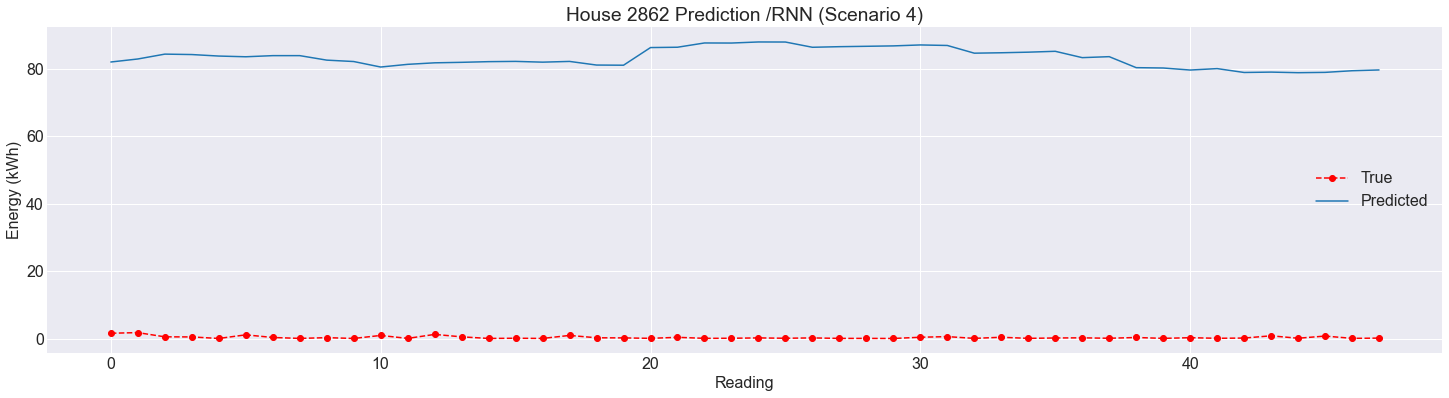

Mse:  34055.791769683964958
Rmse: 184.542113810598693
Mae:  184.489629740593955
Mape:  99.949959976841413


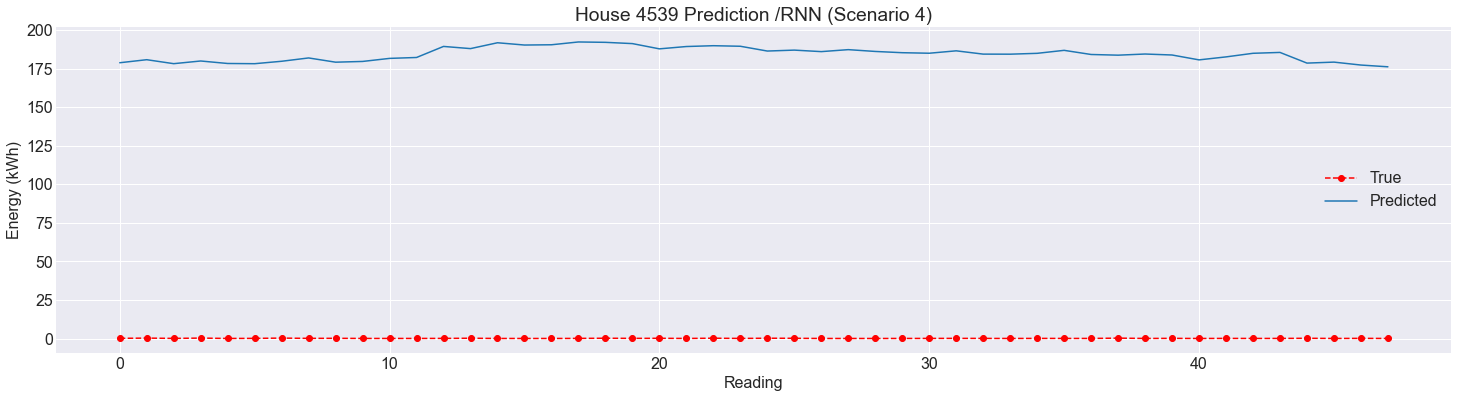

Mse:  12311.877147895143935
Rmse: 110.958898461976204
Mae:  110.949555941430546
Mape:  100.117630558459993


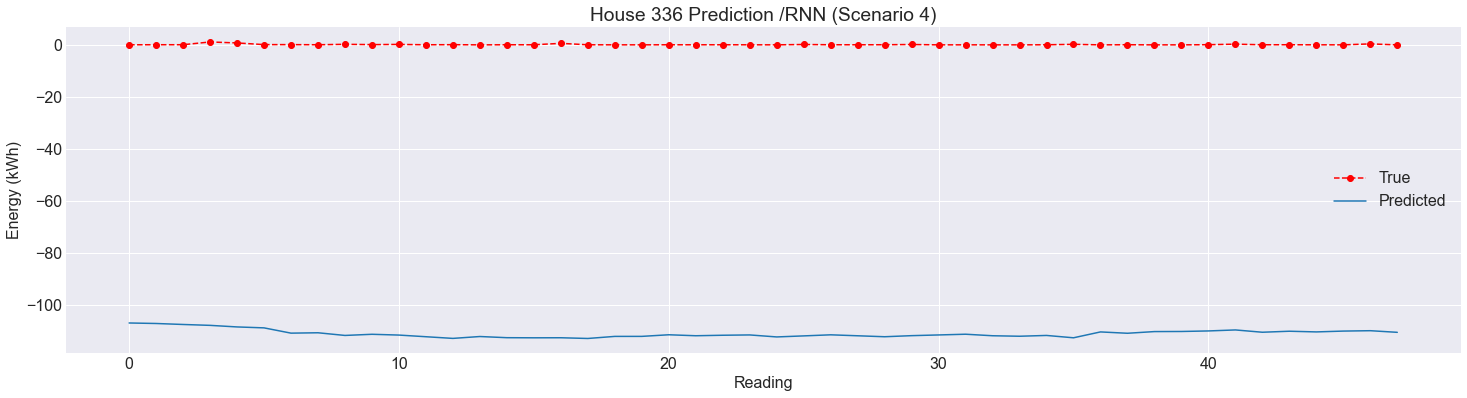

Mse:  13395.439552739160717
Rmse: 115.738669219665567
Mae:  115.732347582932562
Mape:  100.221680704179136


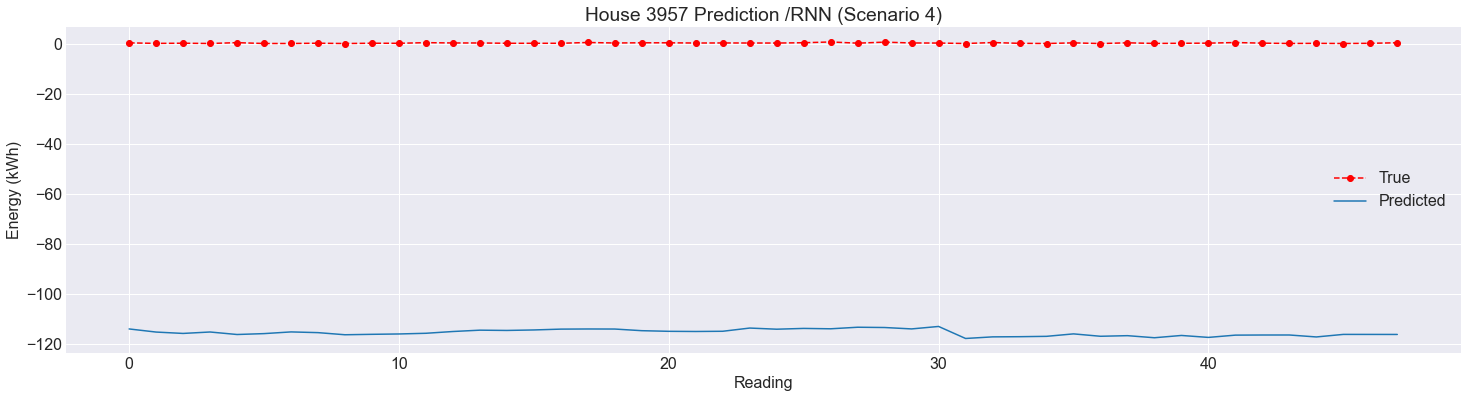

Mse:  37.097627123924916
Rmse: 6.090782143856806
Mae:  5.953020444915940
Mape:  95.344946762930022


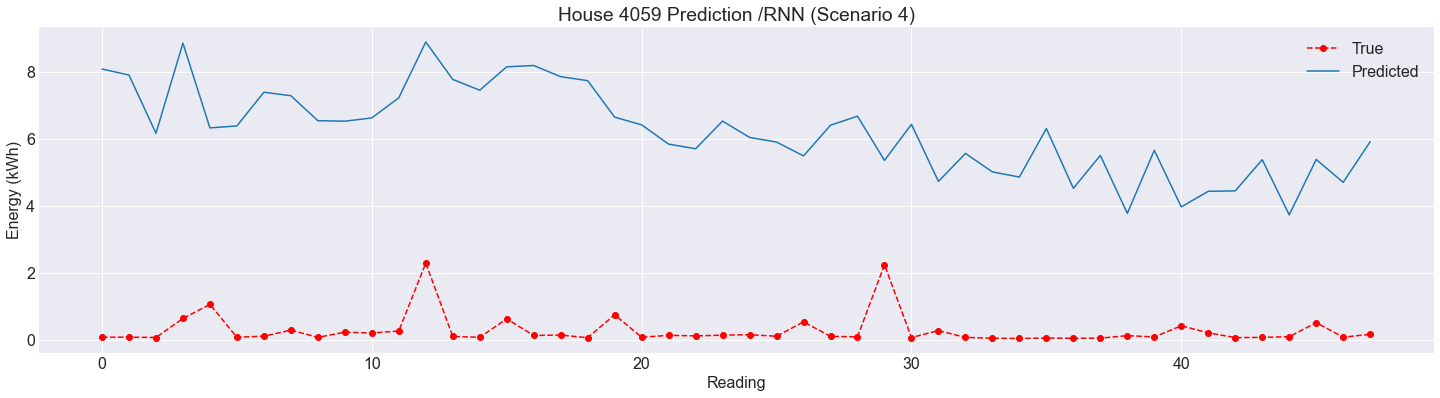

Mse:  66791.141355131156160
Rmse: 258.439821535171234
Mae:  258.429971544828732
Mape:  100.019941583887388


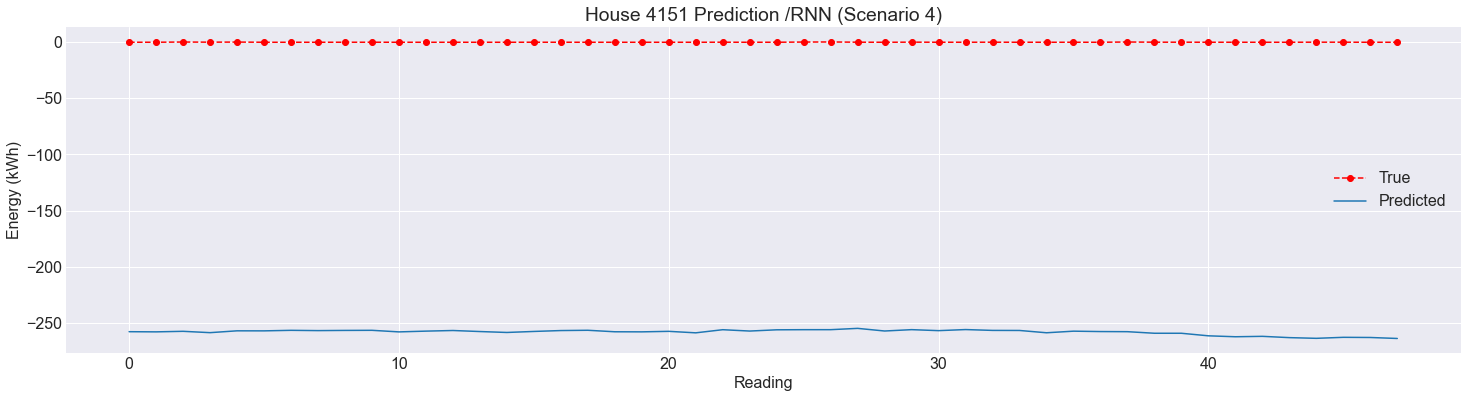

Mse:  4607.605212845543974
Rmse: 67.879343049601943
Mae:  67.863326712977141
Mape:  100.339862476208609


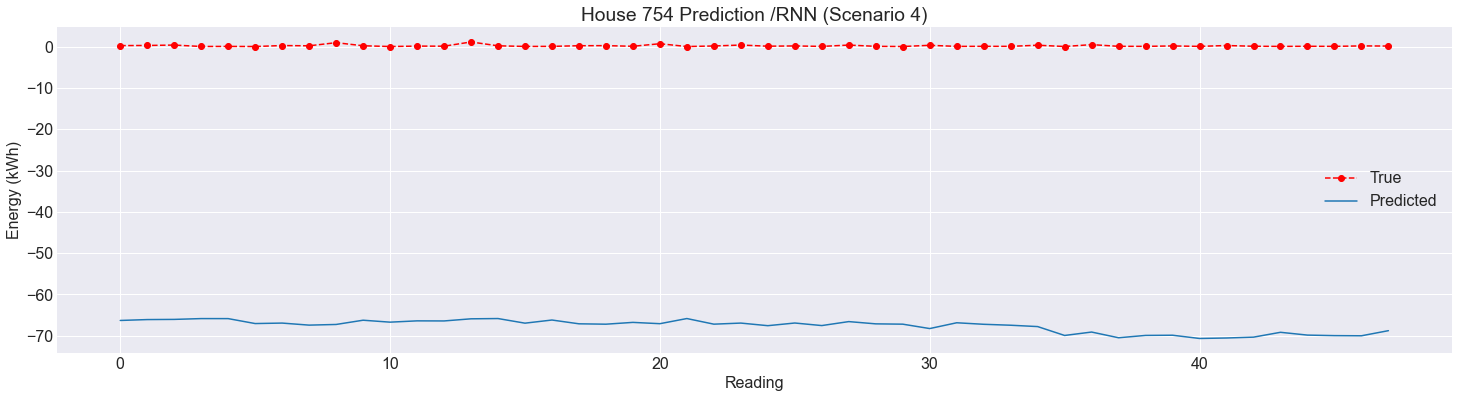

Mse:  56853.056869332474889
Rmse: 238.438790613718055
Mae:  238.435966499440838
Mape:  99.940697582711323


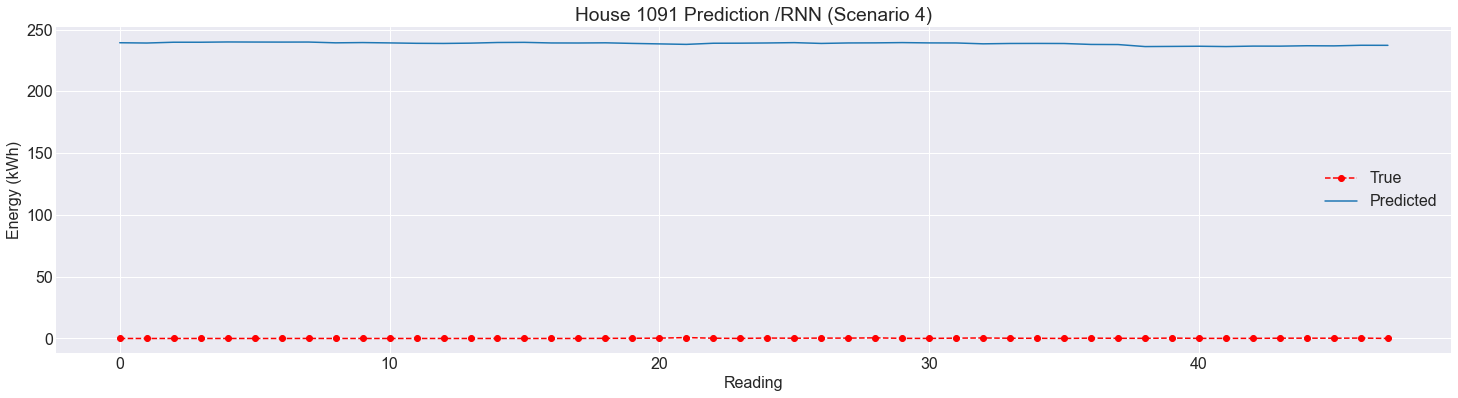

Mse:  32410.742206435668777
Rmse: 180.029836989415912
Mae:  180.022849362188339
Mape:  99.931532020988683


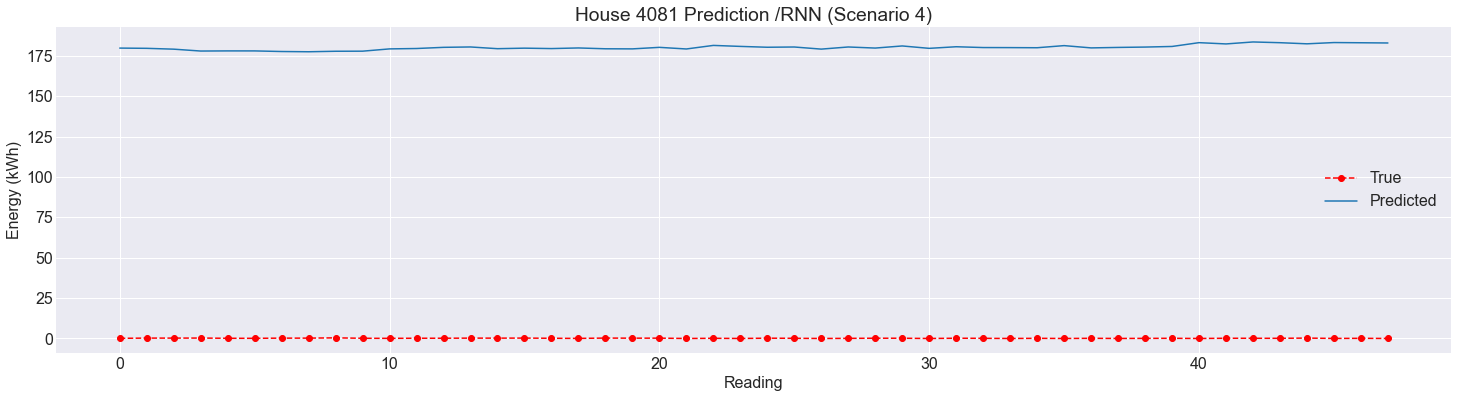

Mse:  1931.765737831505930
Rmse: 43.951857046449199
Mae:  43.789883215446025
Mape:  99.677042056098330


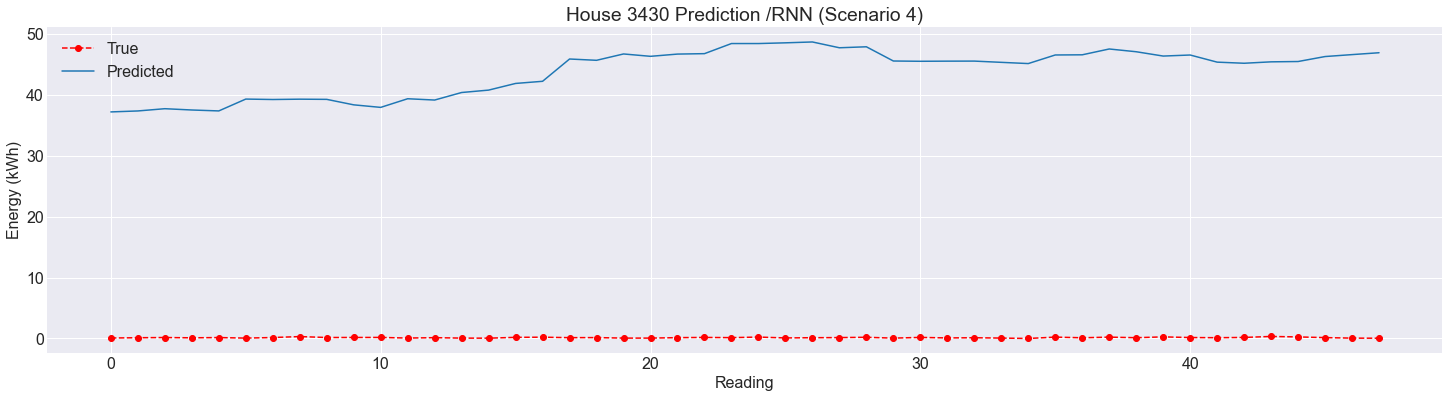

Mse:  38532.975910643828684
Rmse: 196.298181119041004
Mae:  196.296271031567215
Mape:  100.146466701096244


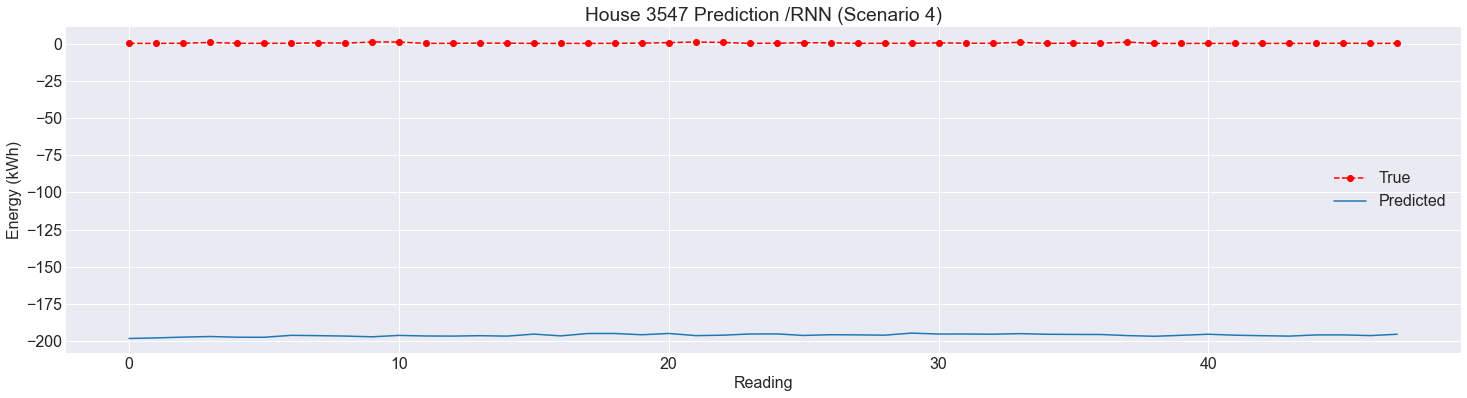

Mse:  37905.507986987700860
Rmse: 194.693369139751923
Mae:  194.679209903193026
Mape:  99.839746543782979


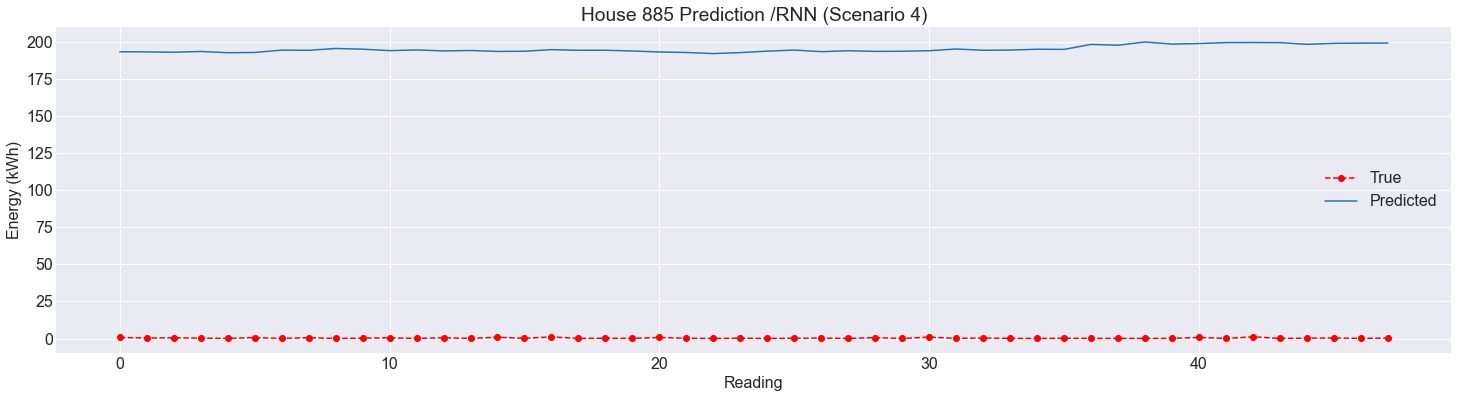

Mse:  3847.507547505765160
Rmse: 62.028280223667053
Mae:  62.006697823448725
Mape:  100.289922778575331


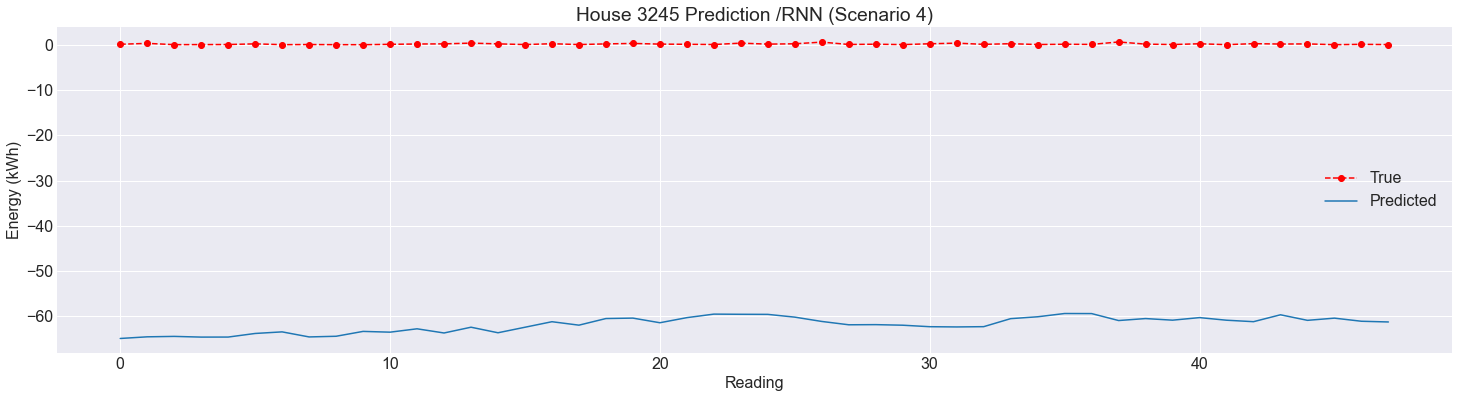

Mse:  274766.892331430397462
Rmse: 524.182117523509532
Mae:  524.180322112826047
Mape:  100.050183178968027


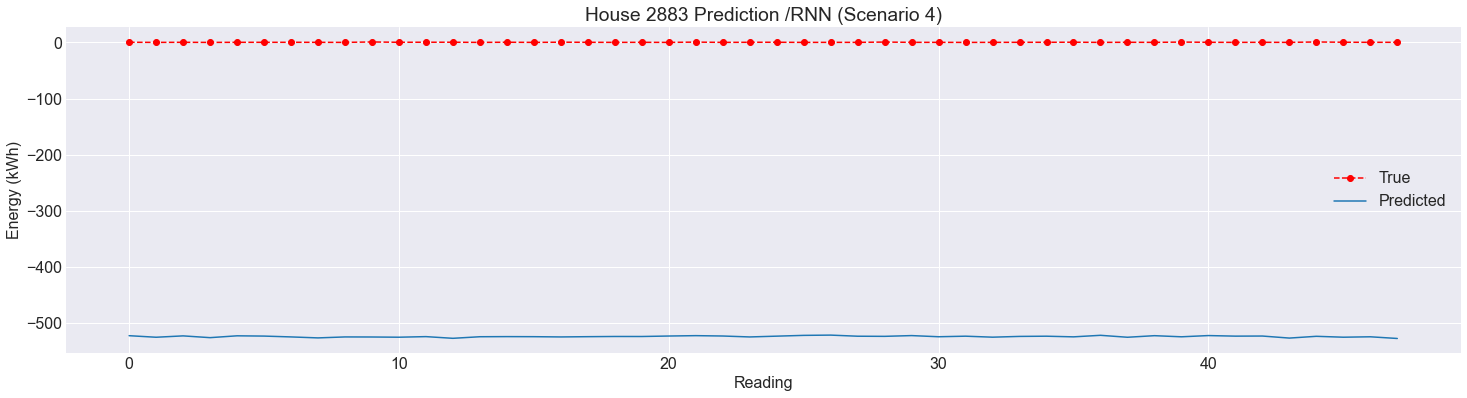

Mse:  14410.653400585526470
Rmse: 120.044380962148850
Mae:  120.033316884694315
Mape:  100.093324343860203


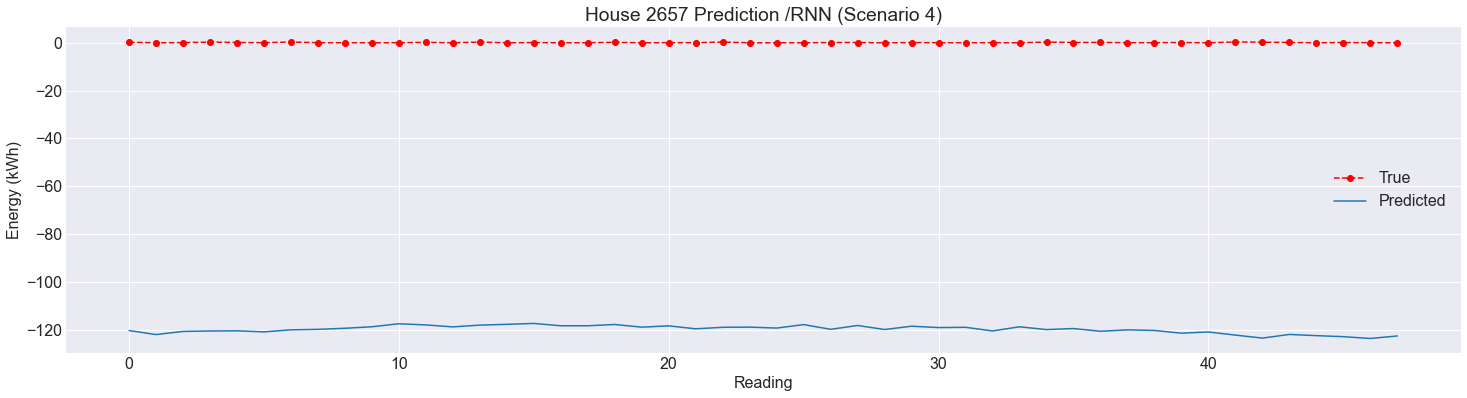

Mse:  156569.657740500086220
Rmse: 395.688839545039571
Mae:  395.687891037125780
Mape:  100.030736668724089


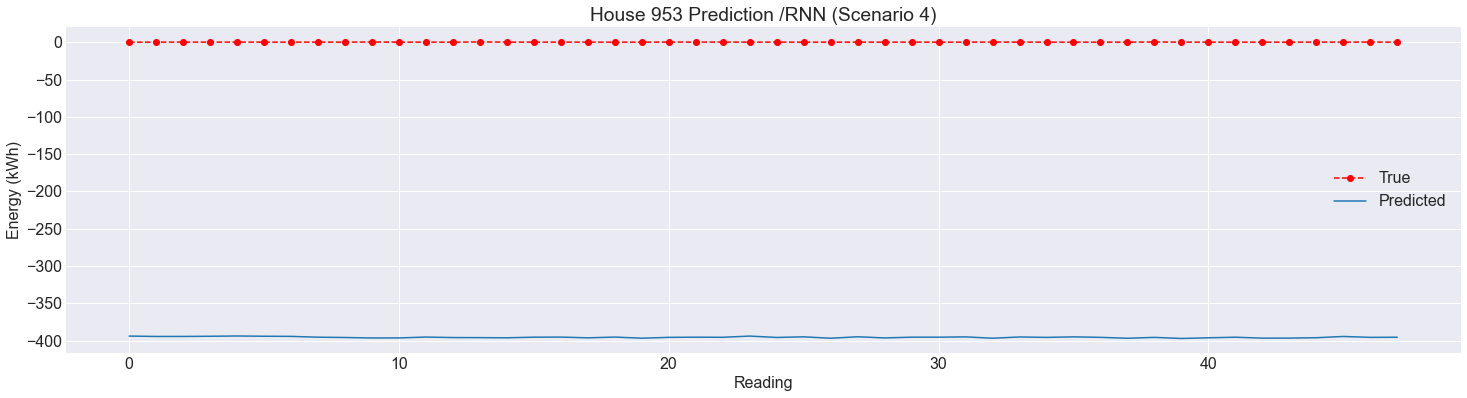

Mse:  73804.483620555314701
Rmse: 271.669806236459237
Mae:  271.665592006097256
Mape:  99.934304784679483


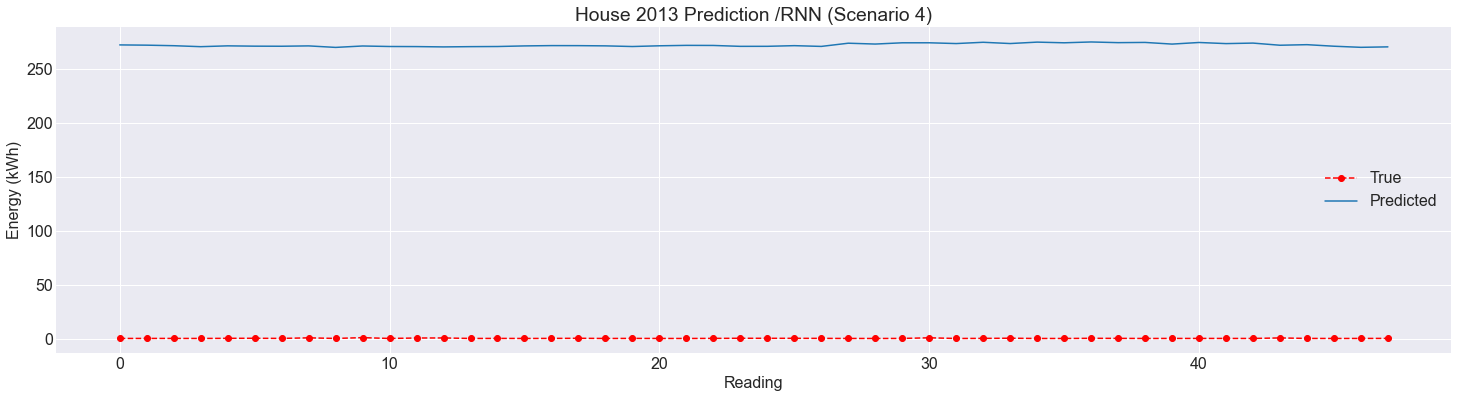

Mse:  16771.249644618685124
Rmse: 129.503859574217643
Mae:  129.497717014630325
Mape:  99.915313776407700


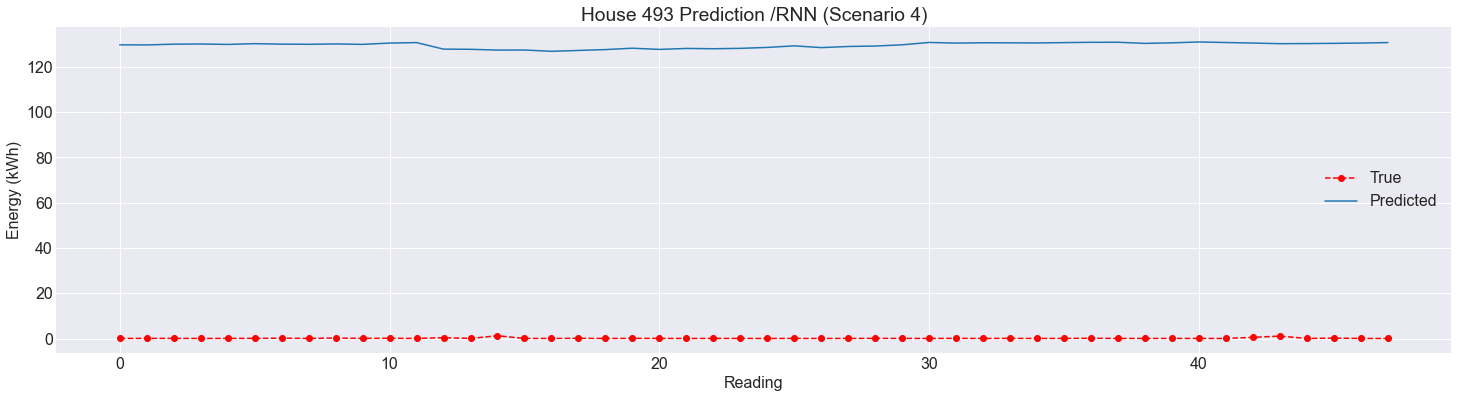

Mse:  16601.960475788018812
Rmse: 128.848595164200447
Mae:  128.842840539291501
Mape:  100.256058936784015


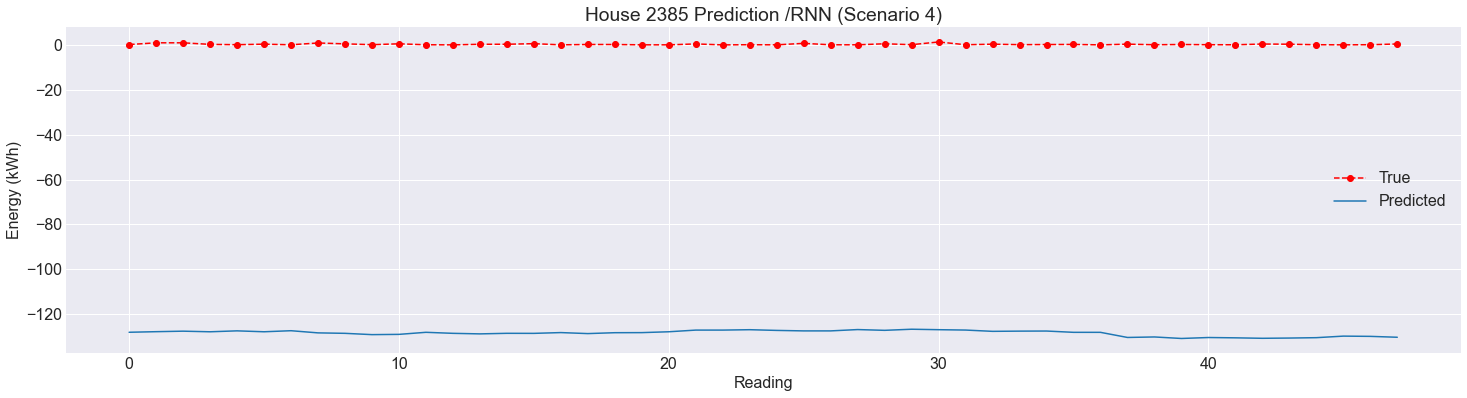

Mse:  1229.382149417998107
Rmse: 35.062546248354501
Mae:  35.035582949485011
Mape:  100.573625462820871


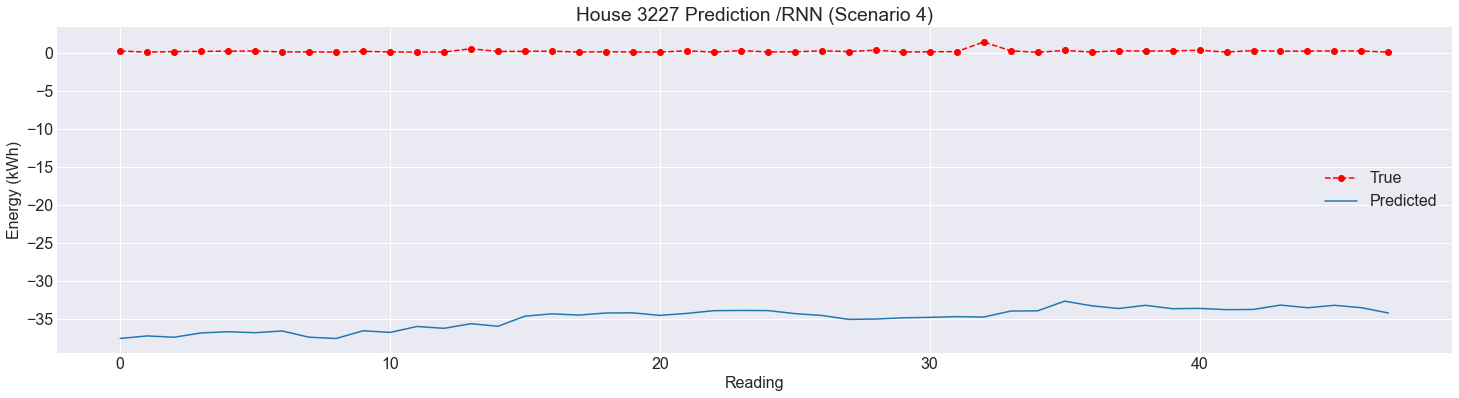

Mse:  512.438689531438740
Rmse: 22.637108683121145
Mae:  22.310804604630295
Mape:  100.717991824975599


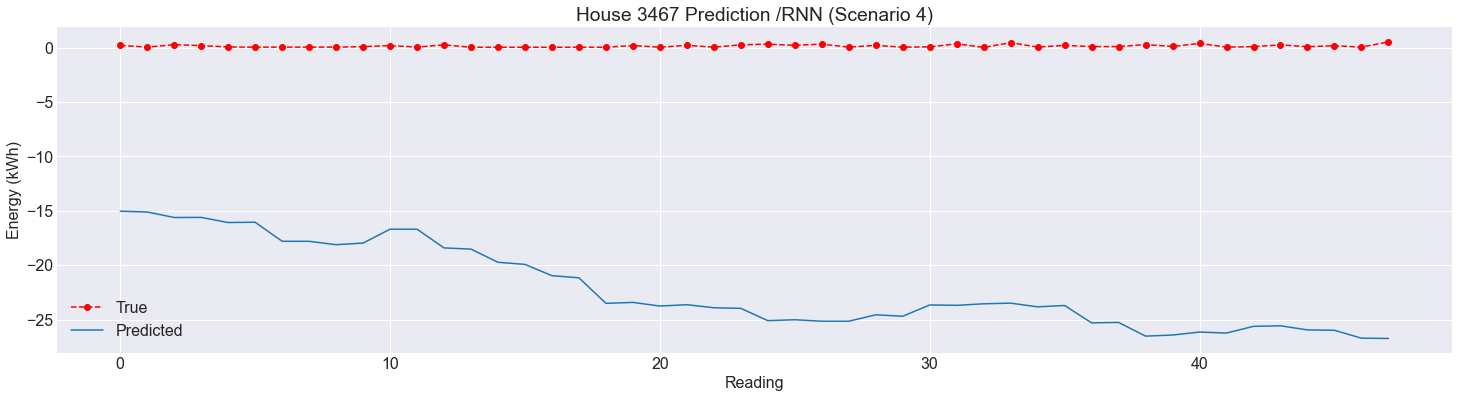

Mse:  141856.393920189002529
Rmse: 376.638279945346255
Mae:  376.635291471611708
Mape:  100.154068094145799


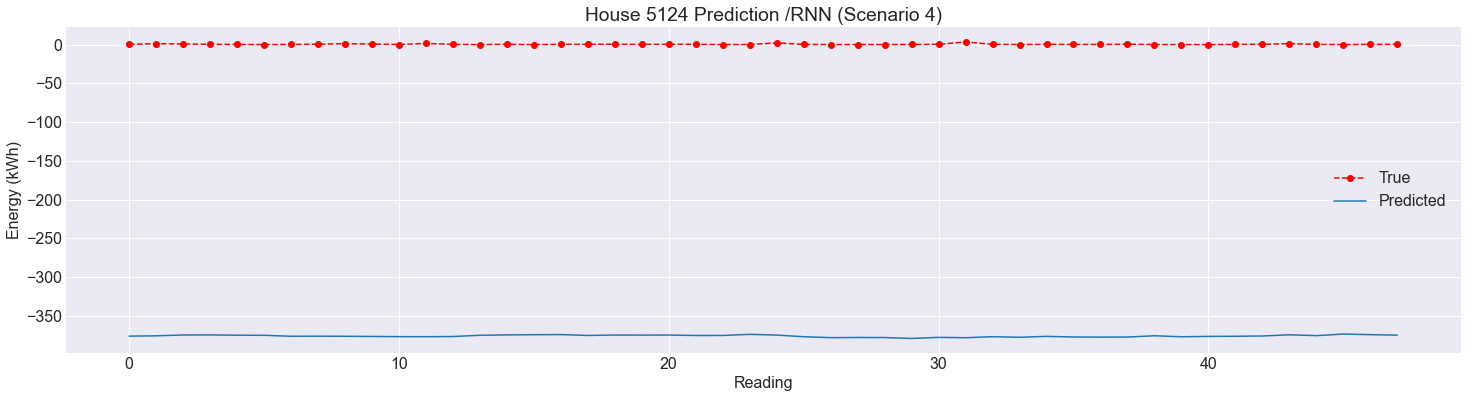

Mse:  10630.469173122606662
Rmse: 103.104166613782425
Mae:  103.056818944091603
Mape:  100.338921417056511


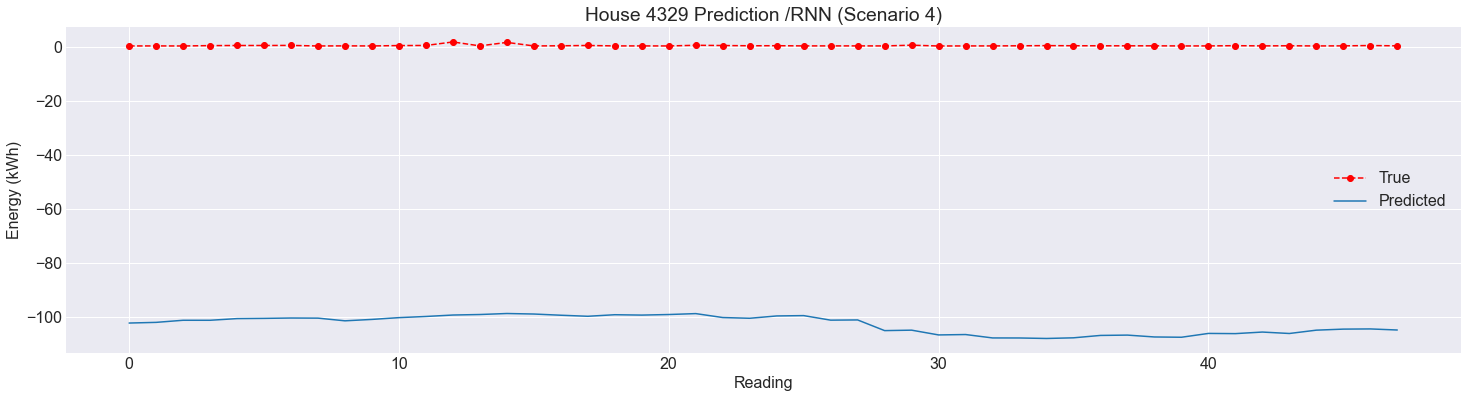

In [88]:
predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)


In [ ]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

HH_1           HH_2          HH_3          HH_4  \
MSE_scores   28848.927743  260758.099555  38883.934858  55199.831380   
RMSE_scores    169.849721     510.644788    197.190098    234.946444   
MAE_scores     169.846227     510.612067    197.188789    234.900292   
MAPE_scores     99.899479      99.952186    100.359108    100.062235   

                      HH_5          HH_6          HH_7          HH_8  \
MSE_scores   228602.882539  82840.478091  11141.687911  57264.318041   
RMSE_scores     478.124338    287.820218    105.554194    239.299641   
MAE_scores      478.117204    287.605802    105.537836    239.218321   
MAPE_scores      99.986524    100.056572     99.670103     99.961399   

                      HH_9        HH_10  ...        HH_20          HH_21  \
MSE_scores   415356.422862  3681.133972  ...  8237.028224  153227.526528   
RMSE_scores     644.481515    60.672349  ...    90.758075     391.442878   
MAE_scores      644.480442    60.662944  ...    90.752426     391.440859   
MAPE_scores      99.979781   100.423864  ...   100.290584     100.028594   

                    HH_22         HH_23         HH_24         HH_25  \
MSE_scores   11961.940291  41754.753724  78369.057112  92731.969296   
RMSE_scores    109.370656    204.339800    279.944739    304.519243   
MAE_scores     109.368740    204.338265    279.943996    304.503854   
MAPE_scores     99.888951    100.087474     99.960811     99.892047   

                    HH_26         HH_27       HH_28       HH_29  
MSE_scores   12724.032590  93756.109743  149.863241  302.224114  
RMSE_scores    112.800854    306.196195   12.241864   17.384594  
MAE_scores     112.734586    306.146001   11.087672   17.173892  
MAPE_scores    100.177509    100.050277  107.760683  102.123917  

[4 rows x 29 columns]

In [ ]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario4.csv', index=False)

In [ ]:
## Best regression model

In [89]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                          'HH_2',
                          'HH_3',
                          'HH_4',
                          'HH_5',
                          'HH_6',
                          'HH_7',
                          'HH_8',
                          'HH_9',
                          'HH_10',
                          'HH_11',
                          'HH_12',
                          'HH_13',
                          'HH_14',
                          'HH_15',
                          'HH_16',
                          'HH_17',
                          'HH_18',
                          'HH_19',
                          'HH_20',
                          'HH_21',
                          'HH_22',
                          'HH_23',
                          'HH_24',
                          'HH_25',
                          'HH_26',
                          'HH_27',
                          'HH_28', 
                          'HH_29']

In [90]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR (Scenario 4)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario4/2_singleHouseholdLevel/best_regression_model/S4_24h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


In [91]:
 ##### The households with an error have a '#' 
predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

HH_1        HH_2        HH_3        HH_4       HH_5  \
MSE_scores    0.015370    0.283005    0.325747    0.033827   0.004752   
RMSE_scores   0.123977    0.531983    0.570742    0.183922   0.068931   
MAE_scores    0.085158    0.473852    0.435180    0.098220   0.050003   
MAPE_scores  43.902176  284.139907  156.090067  105.449725  71.097160   

                    HH_6        HH_7       HH_8        HH_9       HH_10  ...  \
MSE_scores      0.077992    0.201120   0.006698    0.085185    0.045087  ...   
RMSE_scores     0.279270    0.448464   0.081841    0.291865    0.212338  ...   
MAE_scores      0.216885    0.355964   0.072718    0.209341    0.167071  ...   
MAPE_scores  1078.333980  209.659548  53.573099  191.476997  492.193669  ...   

                 HH_20      HH_21      HH_22       HH_23       HH_24  \
MSE_scores    0.036603   0.063684   0.004412    0.103366    0.113013   
RMSE_scores   0.191318   0.252356   0.066421    0.321506    0.336173   
MAE_scores    0.126634   0.228292   0.054800    0.255154    0.248319   
MAPE_scores  58.922129  67.636036  41.916328  164.030458  236.314103   

                  HH_25       HH_26       HH_27       HH_28      HH_29  
MSE_scores     0.113766    0.048708    0.063960    0.494125   0.047826  
RMSE_scores    0.337292    0.220700    0.252903    0.702940   0.218692  
MAE_scores     0.255055    0.133038    0.211314    0.495205   0.144064  
MAPE_scores  214.938503  106.240661  362.897903  189.539714  62.409343  

[4 rows x 29 columns]

In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario4_SVR.csv', index=False)